In [1]:
import pandas as pd
import numpy as np
import re

The first step is to extract the Reddit data from GoogleBig Query. 

The next step is to run the linguistic data through the LIWC software. The data here have been run through the LIWC software using the standard LIWC2015 dictionary.

Here, we outline the code used to clean the data although do not share the raw data due to privacy concerns. As we collect Reddit users' ids and the exact text, by sharing this data we are breaching the users' right to privacy. This is particular important with regards to this research as some of the data could be considered more sensitive (such as usernames of individuals posting in forums such as asktransgender or stopdrinking). 

In [ ]:
comments_data = pd.read_csv('/all_comments.csv')

## Data Preparation

Here we remove comments that are not suitable for the analysis. This includes posts/comments which: 
<br> (i) have been removed or deleted, 
<br> (ii) are from authors who have been removed or deleted, 
<br>(iii) contain strings including the word 'bot' as bots often identify themselves
<br> (iv) contain urls
<br> (v)  contain words under the word count limit (50)

In [ ]:
def clean_comments(df, wordcount):
    print('Comments starting:', df.shape)
    df= df.loc[df['body']!='[removed]']
    df= df.loc[df['body']!='[deleted]']
    print('After body removed/deleted: ', len(df))
    if 'author' in df.columns:
        df= df.loc[df['author']!='[removed]']
        df= df.loc[df['author']!='[deleted]']
        print('After author removed/deleted: ', len(df))
    df=df[~df.body.str.contains(' bot ', na=False)]
    print('text with no bots: ', len(df))
    df=df[~df.author.str.contains('AutoModerator', na=False)]
    if 'author' in df.columns:
        df=df[~df.author.str.contains('bot', na=False)]
    print('After author no bots: ', len(df))
    df['body'] = df['body'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    df = df.loc[df['WC'] > wordcount]
    print('After low WC removed: ', len(df))
    print(df.shape)
    return df

In [ ]:
cleancomments = clean_comments(comments_data, 49)

Here, we drop any duplicate comments in each forum and find out how many comments we have remaining in each forum.

In [ ]:
forums = cleancomments.subreddit.unique()
comment_lengths=[]
for forum in forums:
    cleancomments.drop_duplicates('body', inplace=True)
    comments_filtered = cleancomments.loc[cleancomments['subreddit']==forum]
    print(forum, 'comments : ', len(comments_filtered))
    comment_lengths.append(len(comments_filtered))


The shared anonymous dataset consists of all comments which were not removed during the data preparation stage.  

In [18]:
allstyle = ['WPS', 'Sixltr','i', 'we', 'you', 'shehe', 'they', 'ipron',
       'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb',
       'adj', 'compare', 'interrog', 'number', 'quant', 'affect','insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ','see', 'hear',
       'feel', 'focuspast', 'focuspresent', 'focusfuture', 'motion', 'space',
       'time','swear', 'netspeak', 'assent', 'nonflu', 'filler', 'subreddit']

text = ['body', 'subreddit']

## Data Analysis

In [13]:
cleancomments=pd.read_csv('cleaned_comments.csv')

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from mpl_toolkits import mplot3d
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from mds import mds
from sklearn import manifold
from sklearn.metrics import euclidean_distances

Next, we run the Extra Trees classifier. Here we use 5 fold cross validation. 

In [5]:
def run_classifier(test1, test2, train1, train2):
    test1 = del_subreddit_unnamed(test1)
    test2 = del_subreddit_unnamed(test2)
    train1 = del_subreddit_unnamed(train1)
    train2 = del_subreddit_unnamed(train2)

    print('train1=', len(train1), 'train2=', len(train2), 'test1=', len(test1),'test2= ', len(test2))
    t = np.ones((train1.shape[0]+train2.shape[0]))
    t[:train1.shape[0]] = 0

    X = np.vstack((train1.values, 
            train2.values))
    X.shape, train1.shape, train2.shape
    
    t1 = np.ones((test1.shape[0]+test2.shape[0]))
    t1[:test1.shape[0]] = 0

    t2 = np.vstack((test1.values, 
            test2.values))
    t2.shape, test1.shape, test2.shape

    et = ExtraTreesClassifier(n_estimators=100, max_depth=None, 
                              min_samples_split=2, random_state=8, 
                              n_jobs=-1)

    scores = ['accuracy', 'roc_auc']

    for score in scores:
        result = cross_val_score(et, X, t, cv=5, scoring=score)
        print("ExtraTrees for %s" % score)
        print("%0.3f (+/-%0.03f)" % (np.mean(result), np.std(result)*2))

    print(X.shape)
    et.fit(X, t)
    s_train = et.predict_proba(X)

    y_true, y_pred = t1, et.predict(t2)
    s = et.predict_proba(t2)[:,1]
    print(classification_report(y_true, y_pred))
    print()


    fpr, tpr, thresholds = roc_curve(y_true, s)
    auc = roc_auc_score(y_true, s)
    acc = accuracy_score(y_true, y_pred)
    print('ExtraTrees  AUC %g   Accuracy %g' % (auc, acc))
    return auc, acc

In [6]:
def shortest_df_size(df1, df2):
    if len(df1) < len(df2):
        print(len(df1))
        return len(df1)
    else:
        print(len(df2))
        return len(df2)
    
def del_subreddit_unnamed(df):
    if 'subreddit' in df.columns:
        df.drop('subreddit', axis=1, inplace = True)
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace = True) 
    return df
    
def get_forum_sample(length, df1, df2, df3, df4, a):
    for df in df1, df2, df3, df4:
        df = del_subreddit_unnamed(df)
    train1 = df1.sample(length, random_state=a)
    train2 = df2.sample(length,random_state=a)
    test1 = df3.sample(length,random_state=a)
    test2 = df4.sample(length,random_state=a)
    print(len(train1), len(train2), len(test1), len(test2) )
    return test1, test2, train1, train2

def get_train_test(df):
    df = df.sample(frac=1)
    length = len(df)//2
    train = df[:length]
    test = df[length:]
    return train, test
    

In [19]:
forums = cleancomments.subreddit.unique()
cleancomments = cleancomments[allstyle]
testset=pd.DataFrame()
trainset=pd.DataFrame()

for i in range(len(forums)):
    comments = cleancomments.loc[cleancomments['subreddit']==forums[i]]
    train, test = get_train_test(comments)
    testset= pd.concat([testset, test])
    trainset = pd.concat([trainset, train])


In [16]:
analysisdf = pd.DataFrame(columns=forums, index=forums)

for i in range(len(forums)):
    for j in range(i, len(forums)):
        print(forums[i], forums[j])
        trainset1 = trainset.loc[trainset['subreddit']==forums[i]]
        trainset2 = trainset.loc[trainset['subreddit']==forums[j]]
        testset1 = testset.loc[testset['subreddit']==forums[i]]
        testset2 = testset.loc[testset['subreddit']==forums[j]]
        commentlength = shortest_df_size (trainset1, trainset2)
        test1, test2, train1, train2 = get_forum_sample(commentlength, trainset1, trainset2, testset1, testset2, 75)
        auc, acc = run_classifier(test1, test2, train1, train2)
        analysisdf.at[forums[i], forums[j]] = auc

print(analysisdf)

islam islam
27247
27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(54494, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     27247
         1.0       0.00      0.00      0.00     27247

    accuracy                           0.50     54494
   macro avg       0.25      0.50      0.33     54494
weighted avg       0.25      0.50      0.33     54494


ExtraTrees  AUC 0.5   Accuracy 0.5
islam daddit
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.821 (+/-0.012)
ExtraTrees for roc_auc
0.899 (+/-0.010)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82      8694
         1.0       0.83      0.81      0.82      8694

    accuracy                           0.82     17388
   macro avg       0.82      0.82      0.82     17388
weighted avg       0.82      0.82      0.82     17388


ExtraTrees  AUC 0.901469   Accuracy 0.821084
islam asktransgender
27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247
ExtraTrees for accuracy
0.766 (+/-0.005)
ExtraTrees for roc_auc
0.846 (+/-0.003)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77     27247
         1.0       0.77      0.76      0.77     27247

    accuracy                           0.77     54494
   macro avg       0.77      0.77      0.77     54494
weighted avg       0.77      0.77      0.77     54494


ExtraTrees  AUC 0.849408   Accuracy 0.768782
islam relationships
27247
27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.839 (+/-0.002)
ExtraTrees for roc_auc
0.919 (+/-0.003)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84     27247
         1.0       0.84      0.85      0.84     27247

    accuracy                           0.84     54494
   macro avg       0.84      0.84      0.84     54494
weighted avg       0.84      0.84      0.84     54494


ExtraTrees  AUC 0.919847   Accuracy 0.842478
islam Entrepreneur
27247
27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.772 (+/-0.006)
ExtraTrees for roc_auc
0.852 (+/-0.006)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77     27247
         1.0       0.77      0.78      0.77     27247

    accuracy                           0.77     54494
   macro avg       0.77      0.77      0.77     54494
weighted avg       0.77      0.77      0.77     54494


ExtraTrees  AUC 0.853312   Accuracy 0.772415
islam asianamerican
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.722 (+/-0.018)
ExtraTrees for roc_auc
0.800 (+/-0.016)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.74      0.73      8759
         1.0       0.73      0.71      0.72      8759

    accuracy                           0.73     17518
   macro avg       0.73      0.73      0.73     17518
weighted avg       0.73      0.73      0.73     17518


ExtraTrees  AUC 0.800662   Accuracy 0.726453
islam Feminism
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.671 (+/-0.010)
ExtraTrees for roc_auc
0.736 (+/-0.014)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      7693
         1.0       0.67      0.67      0.67      7693

    accuracy                           0.67     15386
   macro avg       0.67      0.67      0.67     15386
weighted avg       0.67      0.67      0.67     15386


ExtraTrees  AUC 0.734041   Accuracy 0.665605
islam homeless
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.785 (+/-0.025)
ExtraTrees for roc_auc
0.865 (+/-0.019)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78      3874
         1.0       0.79      0.78      0.78      3874

    accuracy                           0.78      7748
   macro avg       0.78      0.78      0.78      7748
weighted avg       0.78      0.78      0.78      7748


ExtraTrees  AUC 0.863682   Accuracy 0.782266
islam breakingmom
27247
27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.847 (+/-0.005)
ExtraTrees for roc_auc
0.923 (+/-0.005)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85     27247
         1.0       0.85      0.85      0.85     27247

    accuracy                           0.85     54494
   macro avg       0.85      0.85      0.85     54494
weighted avg       0.85      0.85      0.85     54494


ExtraTrees  AUC 0.923221   Accuracy 0.846552
islam sales
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.799 (+/-0.007)
ExtraTrees for roc_auc
0.876 (+/-0.008)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79     12628
         1.0       0.79      0.81      0.80     12628

    accuracy                           0.80     25256
   macro avg       0.80      0.80      0.80     25256
weighted avg       0.80      0.80      0.80     25256


ExtraTrees  AUC 0.875473   Accuracy 0.797197
islam Libertarian
27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247
ExtraTrees for accuracy
0.705 (+/-0.010)
ExtraTrees for roc_auc
0.780 (+/-0.012)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71     27247
         1.0       0.71      0.71      0.71     27247

    accuracy                           0.71     54494
   macro avg       0.71      0.71      0.71     54494
weighted avg       0.71      0.71      0.71     54494


ExtraTrees  AUC 0.786112   Accuracy 0.71228
islam Teachers
27247
27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.762 (+/-0.003)
ExtraTrees for roc_auc
0.843 (+/-0.004)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77     27247
         1.0       0.77      0.74      0.76     27247

    accuracy                           0.76     54494
   macro avg       0.76      0.76      0.76     54494
weighted avg       0.76      0.76      0.76     54494


ExtraTrees  AUC 0.844537   Accuracy 0.762433
islam Conservative
27247
27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.693 (+/-0.011)
ExtraTrees for roc_auc
0.764 (+/-0.009)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.70      0.69      0.70     27247
         1.0       0.70      0.71      0.70     27247

    accuracy                           0.70     54494
   macro avg       0.70      0.70      0.70     54494
weighted avg       0.70      0.70      0.70     54494


ExtraTrees  AUC 0.770855   Accuracy 0.700426
islam stopdrinking
27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247
ExtraTrees for accuracy
0.871 (+/-0.002)
ExtraTrees for roc_auc
0.941 (+/-0.002)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     27247
         1.0       0.87      0.87      0.87     27247

    accuracy                           0.87     54494
   macro avg       0.87      0.87      0.87     54494
weighted avg       0.87      0.87      0.87     54494


ExtraTrees  AUC 0.940731   Accuracy 0.868976
islam Christianity
27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247
ExtraTrees for accuracy
0.610 (+/-0.013)
ExtraTrees for roc_auc
0.657 (+/-0.012)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.61      0.63      0.62     27247
         1.0       0.62      0.60      0.61     27247

    accuracy                           0.61     54494
   macro avg       0.61      0.61      0.61     54494
weighted avg       0.61      0.61      0.61     54494


ExtraTrees  AUC 0.664572   Accuracy 0.614104
daddit daddit
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(17388, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      8694
         1.0       0.00      0.00      0.00      8694

    accuracy                           0.50     17388
   macro avg       0.25      0.50      0.33     17388
weighted avg       0.25      0.50      0.33     17388


ExtraTrees  AUC 0.5   Accuracy 0.5
daddit asktransgender
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.787 (+/-0.008)
ExtraTrees for roc_auc
0.868 (+/-0.006)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78      8694
         1.0       0.77      0.81      0.79      8694

    accuracy                           0.78     17388
   macro avg       0.79      0.78      0.78     17388
weighted avg       0.79      0.78      0.78     17388


ExtraTrees  AUC 0.867634   Accuracy 0.784622
daddit relationships
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.782 (+/-0.013)
ExtraTrees for roc_auc
0.866 (+/-0.009)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.79      8694
         1.0       0.79      0.78      0.78      8694

    accuracy                           0.78     17388
   macro avg       0.78      0.78      0.78     17388
weighted avg       0.78      0.78      0.78     17388


ExtraTrees  AUC 0.865785   Accuracy 0.784507
daddit Entrepreneur
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.809 (+/-0.012)
ExtraTrees for roc_auc
0.890 (+/-0.013)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.80      0.81      8694
         1.0       0.80      0.83      0.82      8694

    accuracy                           0.81     17388
   macro avg       0.81      0.81      0.81     17388
weighted avg       0.81      0.81      0.81     17388


ExtraTrees  AUC 0.893001   Accuracy 0.814297
daddit asianamerican
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.801 (+/-0.009)
ExtraTrees for roc_auc
0.881 (+/-0.008)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80      8694
         1.0       0.80      0.80      0.80      8694

    accuracy                           0.80     17388
   macro avg       0.80      0.80      0.80     17388
weighted avg       0.80      0.80      0.80     17388


ExtraTrees  AUC 0.881244   Accuracy 0.800667
daddit Feminism
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.822 (+/-0.011)
ExtraTrees for roc_auc
0.899 (+/-0.007)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82      7693
         1.0       0.82      0.83      0.83      7693

    accuracy                           0.83     15386
   macro avg       0.83      0.83      0.83     15386
weighted avg       0.83      0.83      0.83     15386


ExtraTrees  AUC 0.902121   Accuracy 0.826011
daddit homeless
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.764 (+/-0.021)
ExtraTrees for roc_auc
0.843 (+/-0.007)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76      3874
         1.0       0.76      0.79      0.77      3874

    accuracy                           0.77      7748
   macro avg       0.77      0.77      0.77      7748
weighted avg       0.77      0.77      0.77      7748


ExtraTrees  AUC 0.84794   Accuracy 0.767424
daddit breakingmom
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.637 (+/-0.007)
ExtraTrees for roc_auc
0.687 (+/-0.008)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.63      0.64      0.63      8694
         1.0       0.63      0.62      0.63      8694

    accuracy                           0.63     17388
   macro avg       0.63      0.63      0.63     17388
weighted avg       0.63      0.63      0.63     17388


ExtraTrees  AUC 0.682758   Accuracy 0.629285
daddit sales
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.793 (+/-0.007)
ExtraTrees for roc_auc
0.874 (+/-0.005)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79      8694
         1.0       0.79      0.81      0.80      8694

    accuracy                           0.79     17388
   macro avg       0.80      0.79      0.79     17388
weighted avg       0.80      0.79      0.79     17388


ExtraTrees  AUC 0.872268   Accuracy 0.794859
daddit Libertarian
8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694
ExtraTrees for accuracy
0.861 (+/-0.009)
ExtraTrees for roc_auc
0.934 (+/-0.008)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      8694
         1.0       0.86      0.87      0.86      8694

    accuracy                           0.86     17388
   macro avg       0.86      0.86      0.86     17388
weighted avg       0.86      0.86      0.86     17388


ExtraTrees  AUC 0.934055   Accuracy 0.861859
daddit Teachers
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.751 (+/-0.012)
ExtraTrees for roc_auc
0.828 (+/-0.012)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.75      8694
         1.0       0.75      0.76      0.76      8694

    accuracy                           0.76     17388
   macro avg       0.76      0.76      0.76     17388
weighted avg       0.76      0.76      0.76     17388


ExtraTrees  AUC 0.835122   Accuracy 0.756671
daddit Conservative
8694
8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.835 (+/-0.005)
ExtraTrees for roc_auc
0.915 (+/-0.006)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84      8694
         1.0       0.84      0.84      0.84      8694

    accuracy                           0.84     17388
   macro avg       0.84      0.84      0.84     17388
weighted avg       0.84      0.84      0.84     17388


ExtraTrees  AUC 0.916914   Accuracy 0.839257
daddit stopdrinking
8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694
ExtraTrees for accuracy
0.804 (+/-0.010)
ExtraTrees for roc_auc
0.881 (+/-0.005)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80      8694
         1.0       0.80      0.81      0.80      8694

    accuracy                           0.80     17388
   macro avg       0.80      0.80      0.80     17388
weighted avg       0.80      0.80      0.80     17388


ExtraTrees  AUC 0.881998   Accuracy 0.799862
daddit Christianity
8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694
ExtraTrees for accuracy
0.817 (+/-0.016)
ExtraTrees for roc_auc
0.897 (+/-0.011)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81      8694
         1.0       0.82      0.81      0.81      8694

    accuracy                           0.81     17388
   macro avg       0.81      0.81      0.81     17388
weighted avg       0.81      0.81      0.81     17388


ExtraTrees  AUC 0.896639   Accuracy 0.814355
asktransgender asktransgender
103763


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


103763 103763 103763 103763
train1= 103763 train2= 103763 test1= 103763 test2=  103763
ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(207526, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67    103763
         1.0       0.00      0.00      0.00    103763

    accuracy                           0.50    207526
   macro avg       0.25      0.50      0.33    207526
weighted avg       0.25      0.50      0.33    207526


ExtraTrees  AUC 0.5   Accuracy 0.5
asktransgender relationships
51691


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691
ExtraTrees for accuracy
0.828 (+/-0.005)
ExtraTrees for roc_auc
0.898 (+/-0.005)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83     51691
         1.0       0.85      0.80      0.82     51691

    accuracy                           0.83    103382
   macro avg       0.83      0.83      0.83    103382
weighted avg       0.83      0.83      0.83    103382


ExtraTrees  AUC 0.8987   Accuracy 0.828345
asktransgender Entrepreneur
45507
45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.746 (+/-0.003)
ExtraTrees for roc_auc
0.826 (+/-0.005)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.74      0.75     45507
         1.0       0.75      0.75      0.75     45507

    accuracy                           0.75     91014
   macro avg       0.75      0.75      0.75     91014
weighted avg       0.75      0.75      0.75     91014


ExtraTrees  AUC 0.826567   Accuracy 0.747401
asktransgender asianamerican
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.748 (+/-0.010)
ExtraTrees for roc_auc
0.824 (+/-0.010)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.76      8759
         1.0       0.76      0.74      0.75      8759

    accuracy                           0.75     17518
   macro avg       0.75      0.75      0.75     17518
weighted avg       0.75      0.75      0.75     17518


ExtraTrees  AUC 0.830591   Accuracy 0.753054
asktransgender Feminism
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.738 (+/-0.008)
ExtraTrees for roc_auc
0.811 (+/-0.006)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74      7693
         1.0       0.74      0.74      0.74      7693

    accuracy                           0.74     15386
   macro avg       0.74      0.74      0.74     15386
weighted avg       0.74      0.74      0.74     15386


ExtraTrees  AUC 0.814266   Accuracy 0.740348
asktransgender homeless
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.714 (+/-0.024)
ExtraTrees for roc_auc
0.792 (+/-0.026)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72      3874
         1.0       0.73      0.69      0.71      3874

    accuracy                           0.72      7748
   macro avg       0.72      0.72      0.72      7748
weighted avg       0.72      0.72      0.72      7748


ExtraTrees  AUC 0.794797   Accuracy 0.715927
asktransgender breakingmom
43661
43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.784 (+/-0.004)
ExtraTrees for roc_auc
0.867 (+/-0.003)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79     43661
         1.0       0.80      0.77      0.78     43661

    accuracy                           0.79     87322
   macro avg       0.79      0.79      0.79     87322
weighted avg       0.79      0.79      0.79     87322


ExtraTrees  AUC 0.869415   Accuracy 0.789137
asktransgender sales
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.747 (+/-0.012)
ExtraTrees for roc_auc
0.826 (+/-0.011)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75     12628
         1.0       0.75      0.75      0.75     12628

    accuracy                           0.75     25256
   macro avg       0.75      0.75      0.75     25256
weighted avg       0.75      0.75      0.75     25256


ExtraTrees  AUC 0.832639   Accuracy 0.753168
asktransgender Libertarian
103763


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


103763 103763 103763 103763
train1= 103763 train2= 103763 test1= 103763 test2=  103763
ExtraTrees for accuracy
0.821 (+/-0.002)
ExtraTrees for roc_auc
0.900 (+/-0.002)
(207526, 41)
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82    103763
         1.0       0.81      0.84      0.83    103763

    accuracy                           0.82    207526
   macro avg       0.82      0.82      0.82    207526
weighted avg       0.82      0.82      0.82    207526


ExtraTrees  AUC 0.900678   Accuracy 0.821651
asktransgender Teachers
49398


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398
ExtraTrees for accuracy
0.720 (+/-0.006)
ExtraTrees for roc_auc
0.796 (+/-0.007)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.73      0.72     49398
         1.0       0.72      0.71      0.72     49398

    accuracy                           0.72     98796
   macro avg       0.72      0.72      0.72     98796
weighted avg       0.72      0.72      0.72     98796


ExtraTrees  AUC 0.79568   Accuracy 0.719037
asktransgender Conservative
67383


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


67383 67383 67383 67383
train1= 67383 train2= 67383 test1= 67383 test2=  67383
ExtraTrees for accuracy
0.825 (+/-0.005)
ExtraTrees for roc_auc
0.902 (+/-0.003)
(134766, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82     67383
         1.0       0.82      0.84      0.83     67383

    accuracy                           0.82    134766
   macro avg       0.82      0.82      0.82    134766
weighted avg       0.82      0.82      0.82    134766


ExtraTrees  AUC 0.903128   Accuracy 0.823709
asktransgender stopdrinking
102464


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


102464 102464 102464 102464
train1= 102464 train2= 102464 test1= 102464 test2=  102464
ExtraTrees for accuracy
0.756 (+/-0.006)
ExtraTrees for roc_auc
0.835 (+/-0.006)
(204928, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.75    102464
         1.0       0.75      0.76      0.76    102464

    accuracy                           0.76    204928
   macro avg       0.76      0.76      0.76    204928
weighted avg       0.76      0.76      0.76    204928


ExtraTrees  AUC 0.83487   Accuracy 0.75507
asktransgender Christianity
103763


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


103763 103763 103763 103763
train1= 103763 train2= 103763 test1= 103763 test2=  103763
ExtraTrees for accuracy
0.779 (+/-0.003)
ExtraTrees for roc_auc
0.861 (+/-0.003)
(207526, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78    103763
         1.0       0.78      0.78      0.78    103763

    accuracy                           0.78    207526
   macro avg       0.78      0.78      0.78    207526
weighted avg       0.78      0.78      0.78    207526


ExtraTrees  AUC 0.861728   Accuracy 0.779613
relationships relationships
51691
51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(103382, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     51691
         1.0       0.00      0.00      0.00     51691

    accuracy                           0.50    103382
   macro avg       0.25      0.50      0.33    103382
weighted avg       0.25      0.50      0.33    103382


ExtraTrees  AUC 0.5   Accuracy 0.5
relationships Entrepreneur
45507
45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.870 (+/-0.004)
ExtraTrees for roc_auc
0.940 (+/-0.002)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87     45507
         1.0       0.86      0.90      0.88     45507

    accuracy                           0.87     91014
   macro avg       0.87      0.87      0.87     91014
weighted avg       0.87      0.87      0.87     91014


ExtraTrees  AUC 0.940114   Accuracy 0.872668
relationships asianamerican
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.856 (+/-0.010)
ExtraTrees for roc_auc
0.933 (+/-0.009)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      8759
         1.0       0.86      0.86      0.86      8759

    accuracy                           0.86     17518
   macro avg       0.86      0.86      0.86     17518
weighted avg       0.86      0.86      0.86     17518


ExtraTrees  AUC 0.934019   Accuracy 0.859973
relationships Feminism
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.838 (+/-0.009)
ExtraTrees for roc_auc
0.917 (+/-0.006)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      7693
         1.0       0.84      0.82      0.83      7693

    accuracy                           0.83     15386
   macro avg       0.84      0.83      0.83     15386
weighted avg       0.84      0.83      0.83     15386


ExtraTrees  AUC 0.915985   Accuracy 0.83485
relationships homeless
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.827 (+/-0.012)
ExtraTrees for roc_auc
0.904 (+/-0.010)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82      3874
         1.0       0.81      0.84      0.83      3874

    accuracy                           0.82      7748
   macro avg       0.82      0.82      0.82      7748
weighted avg       0.82      0.82      0.82      7748


ExtraTrees  AUC 0.900559   Accuracy 0.823051
relationships breakingmom
43661
43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.755 (+/-0.006)
ExtraTrees for roc_auc
0.831 (+/-0.004)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.76     43661
         1.0       0.76      0.75      0.75     43661

    accuracy                           0.76     87322
   macro avg       0.76      0.76      0.76     87322
weighted avg       0.76      0.76      0.76     87322


ExtraTrees  AUC 0.83188   Accuracy 0.75509
relationships sales
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.861 (+/-0.012)
ExtraTrees for roc_auc
0.930 (+/-0.009)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.86     12628
         1.0       0.84      0.89      0.86     12628

    accuracy                           0.86     25256
   macro avg       0.86      0.86      0.86     25256
weighted avg       0.86      0.86      0.86     25256


ExtraTrees  AUC 0.931555   Accuracy 0.859756
relationships Libertarian
51691


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691
ExtraTrees for accuracy
0.891 (+/-0.001)
ExtraTrees for roc_auc
0.958 (+/-0.002)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     51691
         1.0       0.89      0.89      0.89     51691

    accuracy                           0.89    103382
   macro avg       0.89      0.89      0.89    103382
weighted avg       0.89      0.89      0.89    103382


ExtraTrees  AUC 0.958749   Accuracy 0.892351
relationships Teachers
49398
49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.844 (+/-0.006)
ExtraTrees for roc_auc
0.918 (+/-0.004)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84     49398
         1.0       0.83      0.86      0.85     49398

    accuracy                           0.84     98796
   macro avg       0.85      0.84      0.84     98796
weighted avg       0.85      0.84      0.84     98796


ExtraTrees  AUC 0.91811   Accuracy 0.844751
relationships Conservative
51691
51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.880 (+/-0.005)
ExtraTrees for roc_auc
0.951 (+/-0.003)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88     51691
         1.0       0.88      0.88      0.88     51691

    accuracy                           0.88    103382
   macro avg       0.88      0.88      0.88    103382
weighted avg       0.88      0.88      0.88    103382


ExtraTrees  AUC 0.951419   Accuracy 0.881188
relationships stopdrinking
51691
51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.873 (+/-0.005)
ExtraTrees for roc_auc
0.942 (+/-0.002)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     51691
         1.0       0.87      0.88      0.87     51691

    accuracy                           0.87    103382
   macro avg       0.87      0.87      0.87    103382
weighted avg       0.87      0.87      0.87    103382


ExtraTrees  AUC 0.940676   Accuracy 0.870587
relationships Christianity
51691


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691
ExtraTrees for accuracy
0.841 (+/-0.005)
ExtraTrees for roc_auc
0.920 (+/-0.003)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     51691
         1.0       0.85      0.83      0.84     51691

    accuracy                           0.84    103382
   macro avg       0.84      0.84      0.84    103382
weighted avg       0.84      0.84      0.84    103382


ExtraTrees  AUC 0.919439   Accuracy 0.841278
Entrepreneur Entrepreneur
45507
45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(91014, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     45507
         1.0       0.00      0.00      0.00     45507

    accuracy                           0.50     91014
   macro avg       0.25      0.50      0.33     91014
weighted avg       0.25      0.50      0.33     91014


ExtraTrees  AUC 0.5   Accuracy 0.5
Entrepreneur asianamerican
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.780 (+/-0.015)
ExtraTrees for roc_auc
0.860 (+/-0.011)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78      8759
         1.0       0.78      0.79      0.78      8759

    accuracy                           0.78     17518
   macro avg       0.78      0.78      0.78     17518
weighted avg       0.78      0.78      0.78     17518


ExtraTrees  AUC 0.863538   Accuracy 0.781196
Entrepreneur Feminism
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.778 (+/-0.011)
ExtraTrees for roc_auc
0.858 (+/-0.011)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      7693
         1.0       0.78      0.79      0.78      7693

    accuracy                           0.78     15386
   macro avg       0.78      0.78      0.78     15386
weighted avg       0.78      0.78      0.78     15386


ExtraTrees  AUC 0.86289   Accuracy 0.783634
Entrepreneur homeless
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.711 (+/-0.031)
ExtraTrees for roc_auc
0.784 (+/-0.029)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.71      3874
         1.0       0.71      0.68      0.69      3874

    accuracy                           0.70      7748
   macro avg       0.70      0.70      0.70      7748
weighted avg       0.70      0.70      0.70      7748


ExtraTrees  AUC 0.768254   Accuracy 0.700181
Entrepreneur breakingmom
43661
43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.841 (+/-0.006)
ExtraTrees for roc_auc
0.916 (+/-0.004)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.85     43661
         1.0       0.85      0.83      0.84     43661

    accuracy                           0.84     87322
   macro avg       0.84      0.84      0.84     87322
weighted avg       0.84      0.84      0.84     87322


ExtraTrees  AUC 0.918331   Accuracy 0.843396
Entrepreneur sales
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.620 (+/-0.011)
ExtraTrees for roc_auc
0.666 (+/-0.014)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.62      0.63      0.63     12628
         1.0       0.63      0.61      0.62     12628

    accuracy                           0.62     25256
   macro avg       0.62      0.62      0.62     25256
weighted avg       0.62      0.62      0.62     25256


ExtraTrees  AUC 0.67074   Accuracy 0.62302
Entrepreneur Libertarian
45507


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507
ExtraTrees for accuracy
0.790 (+/-0.004)
ExtraTrees for roc_auc
0.870 (+/-0.004)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79     45507
         1.0       0.79      0.79      0.79     45507

    accuracy                           0.79     91014
   macro avg       0.79      0.79      0.79     91014
weighted avg       0.79      0.79      0.79     91014


ExtraTrees  AUC 0.87134   Accuracy 0.791428
Entrepreneur Teachers
45507
45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.696 (+/-0.007)
ExtraTrees for roc_auc
0.766 (+/-0.009)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.70     45507
         1.0       0.70      0.69      0.70     45507

    accuracy                           0.70     91014
   macro avg       0.70      0.70      0.70     91014
weighted avg       0.70      0.70      0.70     91014


ExtraTrees  AUC 0.76833   Accuracy 0.699815
Entrepreneur Conservative
45507
45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.807 (+/-0.012)
ExtraTrees for roc_auc
0.886 (+/-0.007)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81     45507
         1.0       0.81      0.81      0.81     45507

    accuracy                           0.81     91014
   macro avg       0.81      0.81      0.81     91014
weighted avg       0.81      0.81      0.81     91014


ExtraTrees  AUC 0.887317   Accuracy 0.807238
Entrepreneur stopdrinking
45507
45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.824 (+/-0.006)
ExtraTrees for roc_auc
0.901 (+/-0.004)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82     45507
         1.0       0.82      0.82      0.82     45507

    accuracy                           0.82     91014
   macro avg       0.82      0.82      0.82     91014
weighted avg       0.82      0.82      0.82     91014


ExtraTrees  AUC 0.901069   Accuracy 0.822928
Entrepreneur Christianity
45507


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507
ExtraTrees for accuracy
0.791 (+/-0.003)
ExtraTrees for roc_auc
0.873 (+/-0.003)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79     45507
         1.0       0.80      0.78      0.79     45507

    accuracy                           0.79     91014
   macro avg       0.79      0.79      0.79     91014
weighted avg       0.79      0.79      0.79     91014


ExtraTrees  AUC 0.874343   Accuracy 0.791527
asianamerican asianamerican
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(17518, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      8759
         1.0       0.00      0.00      0.00      8759

    accuracy                           0.50     17518
   macro avg       0.25      0.50      0.33     17518
weighted avg       0.25      0.50      0.33     17518


ExtraTrees  AUC 0.5   Accuracy 0.5
asianamerican Feminism
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.666 (+/-0.019)
ExtraTrees for roc_auc
0.721 (+/-0.014)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.66      0.67      0.66      7693
         1.0       0.66      0.66      0.66      7693

    accuracy                           0.66     15386
   macro avg       0.66      0.66      0.66     15386
weighted avg       0.66      0.66      0.66     15386


ExtraTrees  AUC 0.721742   Accuracy 0.66268
asianamerican homeless
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.777 (+/-0.031)
ExtraTrees for roc_auc
0.858 (+/-0.029)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78      3874
         1.0       0.79      0.76      0.78      3874

    accuracy                           0.78      7748
   macro avg       0.78      0.78      0.78      7748
weighted avg       0.78      0.78      0.78      7748


ExtraTrees  AUC 0.865892   Accuracy 0.779943
asianamerican breakingmom
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.812 (+/-0.005)
ExtraTrees for roc_auc
0.891 (+/-0.004)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      8759
         1.0       0.80      0.84      0.82      8759

    accuracy                           0.81     17518
   macro avg       0.81      0.81      0.81     17518
weighted avg       0.81      0.81      0.81     17518


ExtraTrees  AUC 0.892782   Accuracy 0.81402
asianamerican sales
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.801 (+/-0.009)
ExtraTrees for roc_auc
0.882 (+/-0.007)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80      8759
         1.0       0.81      0.78      0.79      8759

    accuracy                           0.80     17518
   macro avg       0.80      0.80      0.80     17518
weighted avg       0.80      0.80      0.80     17518


ExtraTrees  AUC 0.87978   Accuracy 0.798436
asianamerican Libertarian
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.747 (+/-0.011)
ExtraTrees for roc_auc
0.823 (+/-0.010)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75      8759
         1.0       0.75      0.76      0.75      8759

    accuracy                           0.75     17518
   macro avg       0.75      0.75      0.75     17518
weighted avg       0.75      0.75      0.75     17518


ExtraTrees  AUC 0.826391   Accuracy 0.752426
asianamerican Teachers
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.742 (+/-0.016)
ExtraTrees for roc_auc
0.819 (+/-0.014)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74      8759
         1.0       0.74      0.74      0.74      8759

    accuracy                           0.74     17518
   macro avg       0.74      0.74      0.74     17518
weighted avg       0.74      0.74      0.74     17518


ExtraTrees  AUC 0.819255   Accuracy 0.738783
asianamerican Conservative
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.700 (+/-0.012)
ExtraTrees for roc_auc
0.768 (+/-0.008)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70      8759
         1.0       0.70      0.70      0.70      8759

    accuracy                           0.70     17518
   macro avg       0.70      0.70      0.70     17518
weighted avg       0.70      0.70      0.70     17518


ExtraTrees  AUC 0.76555   Accuracy 0.700594
asianamerican stopdrinking
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.845 (+/-0.004)
ExtraTrees for roc_auc
0.923 (+/-0.005)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84      8759
         1.0       0.84      0.86      0.85      8759

    accuracy                           0.85     17518
   macro avg       0.85      0.85      0.85     17518
weighted avg       0.85      0.85      0.85     17518


ExtraTrees  AUC 0.923829   Accuracy 0.846786
asianamerican Christianity
8759
8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.745 (+/-0.024)
ExtraTrees for roc_auc
0.824 (+/-0.018)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75      8759
         1.0       0.75      0.74      0.75      8759

    accuracy                           0.75     17518
   macro avg       0.75      0.75      0.75     17518
weighted avg       0.75      0.75      0.75     17518


ExtraTrees  AUC 0.825144   Accuracy 0.748944
Feminism Feminism
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.499 (+/-0.001)
(15386, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      7693
         1.0       0.00      0.00      0.00      7693

    accuracy                           0.50     15386
   macro avg       0.25      0.50      0.33     15386
weighted avg       0.25      0.50      0.33     15386


ExtraTrees  AUC 0.5   Accuracy 0.5
Feminism homeless
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.787 (+/-0.021)
ExtraTrees for roc_auc
0.864 (+/-0.010)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79      3874
         1.0       0.81      0.75      0.78      3874

    accuracy                           0.79      7748
   macro avg       0.79      0.79      0.79      7748
weighted avg       0.79      0.79      0.79      7748


ExtraTrees  AUC 0.868281   Accuracy 0.786138
Feminism breakingmom
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.830 (+/-0.005)
ExtraTrees for roc_auc
0.906 (+/-0.005)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83      7693
         1.0       0.82      0.84      0.83      7693

    accuracy                           0.83     15386
   macro avg       0.83      0.83      0.83     15386
weighted avg       0.83      0.83      0.83     15386


ExtraTrees  AUC 0.906735   Accuracy 0.831275
Feminism sales
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.809 (+/-0.008)
ExtraTrees for roc_auc
0.888 (+/-0.005)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81      7693
         1.0       0.82      0.79      0.80      7693

    accuracy                           0.81     15386
   macro avg       0.81      0.81      0.81     15386
weighted avg       0.81      0.81      0.81     15386


ExtraTrees  AUC 0.885566   Accuracy 0.805862
Feminism Libertarian
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.660 (+/-0.018)
ExtraTrees for roc_auc
0.722 (+/-0.018)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67      7693
         1.0       0.67      0.66      0.66      7693

    accuracy                           0.67     15386
   macro avg       0.67      0.67      0.67     15386
weighted avg       0.67      0.67      0.67     15386


ExtraTrees  AUC 0.726689   Accuracy 0.66528
Feminism Teachers
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.748 (+/-0.017)
ExtraTrees for roc_auc
0.823 (+/-0.011)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.78      0.76      7693
         1.0       0.77      0.71      0.74      7693

    accuracy                           0.75     15386
   macro avg       0.75      0.75      0.75     15386
weighted avg       0.75      0.75      0.75     15386


ExtraTrees  AUC 0.826219   Accuracy 0.747953
Feminism Conservative
7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693
ExtraTrees for accuracy
0.665 (+/-0.012)
ExtraTrees for roc_auc
0.724 (+/-0.018)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.66      0.70      0.68      7693
         1.0       0.68      0.65      0.66      7693

    accuracy                           0.67     15386
   macro avg       0.67      0.67      0.67     15386
weighted avg       0.67      0.67      0.67     15386


ExtraTrees  AUC 0.731301   Accuracy 0.672624
Feminism stopdrinking
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.858 (+/-0.010)
ExtraTrees for roc_auc
0.934 (+/-0.004)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      7693
         1.0       0.87      0.85      0.86      7693

    accuracy                           0.86     15386
   macro avg       0.86      0.86      0.86     15386
weighted avg       0.86      0.86      0.86     15386


ExtraTrees  AUC 0.934429   Accuracy 0.859548
Feminism Christianity
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.662 (+/-0.016)
ExtraTrees for roc_auc
0.729 (+/-0.018)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.65      0.70      0.68      7693
         1.0       0.68      0.62      0.65      7693

    accuracy                           0.66     15386
   macro avg       0.67      0.66      0.66     15386
weighted avg       0.67      0.66      0.66     15386


ExtraTrees  AUC 0.730508   Accuracy 0.66398
homeless homeless
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.001)
(7748, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      3874
         1.0       0.00      0.00      0.00      3874

    accuracy                           0.50      7748
   macro avg       0.25      0.50      0.33      7748
weighted avg       0.25      0.50      0.33      7748


ExtraTrees  AUC 0.5   Accuracy 0.5
homeless breakingmom
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.774 (+/-0.022)
ExtraTrees for roc_auc
0.849 (+/-0.024)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.78      0.78      3874
         1.0       0.78      0.77      0.77      3874

    accuracy                           0.78      7748
   macro avg       0.78      0.78      0.78      7748
weighted avg       0.78      0.78      0.78      7748


ExtraTrees  AUC 0.855174   Accuracy 0.775039
homeless sales
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.672 (+/-0.014)
ExtraTrees for roc_auc
0.736 (+/-0.018)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.67      0.70      0.69      3874
         1.0       0.69      0.65      0.67      3874

    accuracy                           0.68      7748
   macro avg       0.68      0.68      0.68      7748
weighted avg       0.68      0.68      0.68      7748


ExtraTrees  AUC 0.73846   Accuracy 0.67811
homeless Libertarian
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.807 (+/-0.026)
ExtraTrees for roc_auc
0.884 (+/-0.018)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81      3874
         1.0       0.80      0.81      0.81      3874

    accuracy                           0.81      7748
   macro avg       0.81      0.81      0.81      7748
weighted avg       0.81      0.81      0.81      7748


ExtraTrees  AUC 0.885612   Accuracy 0.807047
homeless Teachers
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.681 (+/-0.015)
ExtraTrees for roc_auc
0.742 (+/-0.019)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      3874
         1.0       0.68      0.68      0.68      3874

    accuracy                           0.68      7748
   macro avg       0.68      0.68      0.68      7748
weighted avg       0.68      0.68      0.68      7748


ExtraTrees  AUC 0.753874   Accuracy 0.679659
homeless Conservative
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.808 (+/-0.022)
ExtraTrees for roc_auc
0.886 (+/-0.017)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81      3874
         1.0       0.81      0.81      0.81      3874

    accuracy                           0.81      7748
   macro avg       0.81      0.81      0.81      7748
weighted avg       0.81      0.81      0.81      7748


ExtraTrees  AUC 0.885355   Accuracy 0.808854
homeless stopdrinking
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.794 (+/-0.008)
ExtraTrees for roc_auc
0.872 (+/-0.003)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      3874
         1.0       0.78      0.79      0.79      3874

    accuracy                           0.78      7748
   macro avg       0.78      0.78      0.78      7748
weighted avg       0.78      0.78      0.78      7748


ExtraTrees  AUC 0.867358   Accuracy 0.784202
homeless Christianity
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.801 (+/-0.021)
ExtraTrees for roc_auc
0.879 (+/-0.019)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80      3874
         1.0       0.80      0.80      0.80      3874

    accuracy                           0.80      7748
   macro avg       0.80      0.80      0.80      7748
weighted avg       0.80      0.80      0.80      7748


ExtraTrees  AUC 0.88628   Accuracy 0.803949
breakingmom breakingmom
43661
43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(87322, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     43661
         1.0       0.00      0.00      0.00     43661

    accuracy                           0.50     87322
   macro avg       0.25      0.50      0.33     87322
weighted avg       0.25      0.50      0.33     87322


ExtraTrees  AUC 0.5   Accuracy 0.5
breakingmom sales
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.819 (+/-0.008)
ExtraTrees for roc_auc
0.895 (+/-0.012)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82     12628
         1.0       0.82      0.82      0.82     12628

    accuracy                           0.82     25256
   macro avg       0.82      0.82      0.82     25256
weighted avg       0.82      0.82      0.82     25256


ExtraTrees  AUC 0.893979   Accuracy 0.819568
breakingmom Libertarian
43661
43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.882 (+/-0.006)
ExtraTrees for roc_auc
0.951 (+/-0.004)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88     43661
         1.0       0.89      0.88      0.88     43661

    accuracy                           0.88     87322
   macro avg       0.88      0.88      0.88     87322
weighted avg       0.88      0.88      0.88     87322


ExtraTrees  AUC 0.951753   Accuracy 0.883168
breakingmom Teachers
43661
43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.769 (+/-0.007)
ExtraTrees for roc_auc
0.845 (+/-0.006)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77     43661
         1.0       0.77      0.78      0.77     43661

    accuracy                           0.77     87322
   macro avg       0.77      0.77      0.77     87322
weighted avg       0.77      0.77      0.77     87322


ExtraTrees  AUC 0.847528   Accuracy 0.771329
breakingmom Conservative
43661
43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.860 (+/-0.004)
ExtraTrees for roc_auc
0.935 (+/-0.003)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86     43661
         1.0       0.87      0.85      0.86     43661

    accuracy                           0.86     87322
   macro avg       0.86      0.86      0.86     87322
weighted avg       0.86      0.86      0.86     87322


ExtraTrees  AUC 0.936247   Accuracy 0.863081
breakingmom stopdrinking
43661
43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.801 (+/-0.006)
ExtraTrees for roc_auc
0.876 (+/-0.005)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80     43661
         1.0       0.79      0.82      0.80     43661

    accuracy                           0.80     87322
   macro avg       0.80      0.80      0.80     87322
weighted avg       0.80      0.80      0.80     87322


ExtraTrees  AUC 0.875328   Accuracy 0.800016
breakingmom Christianity
43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661
ExtraTrees for accuracy
0.844 (+/-0.004)
ExtraTrees for roc_auc
0.920 (+/-0.004)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84     43661
         1.0       0.85      0.83      0.84     43661

    accuracy                           0.84     87322
   macro avg       0.84      0.84      0.84     87322
weighted avg       0.84      0.84      0.84     87322


ExtraTrees  AUC 0.920192   Accuracy 0.842216
sales sales
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(25256, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     12628
         1.0       0.00      0.00      0.00     12628

    accuracy                           0.50     25256
   macro avg       0.25      0.50      0.33     25256
weighted avg       0.25      0.50      0.33     25256


ExtraTrees  AUC 0.5   Accuracy 0.5
sales Libertarian
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.819 (+/-0.008)
ExtraTrees for roc_auc
0.899 (+/-0.006)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81     12628
         1.0       0.82      0.80      0.81     12628

    accuracy                           0.81     25256
   macro avg       0.81      0.81      0.81     25256
weighted avg       0.81      0.81      0.81     25256


ExtraTrees  AUC 0.89504   Accuracy 0.812361
sales Teachers
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.659 (+/-0.007)
ExtraTrees for roc_auc
0.716 (+/-0.009)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66     12628
         1.0       0.66      0.66      0.66     12628

    accuracy                           0.66     25256
   macro avg       0.66      0.66      0.66     25256
weighted avg       0.66      0.66      0.66     25256


ExtraTrees  AUC 0.716217   Accuracy 0.659051
sales Conservative
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.825 (+/-0.005)
ExtraTrees for roc_auc
0.903 (+/-0.006)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.82     12628
         1.0       0.82      0.81      0.82     12628

    accuracy                           0.82     25256
   macro avg       0.82      0.82      0.82     25256
weighted avg       0.82      0.82      0.82     25256


ExtraTrees  AUC 0.899767   Accuracy 0.817825
sales stopdrinking
12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628
ExtraTrees for accuracy
0.807 (+/-0.004)
ExtraTrees for roc_auc
0.886 (+/-0.005)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81     12628
         1.0       0.81      0.81      0.81     12628

    accuracy                           0.81     25256
   macro avg       0.81      0.81      0.81     25256
weighted avg       0.81      0.81      0.81     25256


ExtraTrees  AUC 0.885667   Accuracy 0.806303
sales Christianity
12628
12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.812 (+/-0.014)
ExtraTrees for roc_auc
0.892 (+/-0.011)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81     12628
         1.0       0.81      0.80      0.81     12628

    accuracy                           0.81     25256
   macro avg       0.81      0.81      0.81     25256
weighted avg       0.81      0.81      0.81     25256


ExtraTrees  AUC 0.887955   Accuracy 0.808798
Libertarian Libertarian
178481


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


178481 178481 178481 178481
train1= 178481 train2= 178481 test1= 178481 test2=  178481
ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(356962, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67    178481
         1.0       0.00      0.00      0.00    178481

    accuracy                           0.50    356962
   macro avg       0.25      0.50      0.33    356962
weighted avg       0.25      0.50      0.33    356962


ExtraTrees  AUC 0.5   Accuracy 0.5
Libertarian Teachers
49398


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398
ExtraTrees for accuracy
0.794 (+/-0.004)
ExtraTrees for roc_auc
0.872 (+/-0.005)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80     49398
         1.0       0.81      0.76      0.79     49398

    accuracy                           0.79     98796
   macro avg       0.79      0.79      0.79     98796
weighted avg       0.79      0.79      0.79     98796


ExtraTrees  AUC 0.870618   Accuracy 0.792056
Libertarian Conservative
67383


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


67383 67383 67383 67383
train1= 67383 train2= 67383 test1= 67383 test2=  67383
ExtraTrees for accuracy
0.632 (+/-0.007)
ExtraTrees for roc_auc
0.681 (+/-0.006)
(134766, 41)
              precision    recall  f1-score   support

         0.0       0.63      0.64      0.63     67383
         1.0       0.63      0.62      0.63     67383

    accuracy                           0.63    134766
   macro avg       0.63      0.63      0.63    134766
weighted avg       0.63      0.63      0.63    134766


ExtraTrees  AUC 0.679295   Accuracy 0.630597
Libertarian stopdrinking
102464


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


102464 102464 102464 102464
train1= 102464 train2= 102464 test1= 102464 test2=  102464
ExtraTrees for accuracy
0.904 (+/-0.004)
ExtraTrees for roc_auc
0.964 (+/-0.002)
(204928, 41)
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90    102464
         1.0       0.91      0.89      0.90    102464

    accuracy                           0.90    204928
   macro avg       0.90      0.90      0.90    204928
weighted avg       0.90      0.90      0.90    204928


ExtraTrees  AUC 0.964013   Accuracy 0.902083
Libertarian Christianity
178302


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


178302 178302 178302 178302
train1= 178302 train2= 178302 test1= 178302 test2=  178302
ExtraTrees for accuracy
0.714 (+/-0.003)
ExtraTrees for roc_auc
0.790 (+/-0.003)
(356604, 41)
              precision    recall  f1-score   support

         0.0       0.70      0.74      0.72    178302
         1.0       0.73      0.68      0.71    178302

    accuracy                           0.71    356604
   macro avg       0.71      0.71      0.71    356604
weighted avg       0.71      0.71      0.71    356604


ExtraTrees  AUC 0.789496   Accuracy 0.713823
Teachers Teachers
49398
49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(98796, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     49398
         1.0       0.00      0.00      0.00     49398

    accuracy                           0.50     98796
   macro avg       0.25      0.50      0.33     98796
weighted avg       0.25      0.50      0.33     98796


ExtraTrees  AUC 0.5   Accuracy 0.5
Teachers Conservative
49398
49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.781 (+/-0.007)
ExtraTrees for roc_auc
0.860 (+/-0.006)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78     49398
         1.0       0.78      0.79      0.78     49398

    accuracy                           0.78     98796
   macro avg       0.78      0.78      0.78     98796
weighted avg       0.78      0.78      0.78     98796


ExtraTrees  AUC 0.860234   Accuracy 0.781297
Teachers stopdrinking
49398
49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.781 (+/-0.004)
ExtraTrees for roc_auc
0.857 (+/-0.002)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78     49398
         1.0       0.78      0.79      0.78     49398

    accuracy                           0.78     98796
   macro avg       0.78      0.78      0.78     98796
weighted avg       0.78      0.78      0.78     98796


ExtraTrees  AUC 0.85867   Accuracy 0.783625
Teachers Christianity
49398


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398
ExtraTrees for accuracy
0.769 (+/-0.002)
ExtraTrees for roc_auc
0.851 (+/-0.004)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.76      0.77     49398
         1.0       0.77      0.77      0.77     49398

    accuracy                           0.77     98796
   macro avg       0.77      0.77      0.77     98796
weighted avg       0.77      0.77      0.77     98796


ExtraTrees  AUC 0.849327   Accuracy 0.76743
Conservative Conservative
67383
67383 67383 67383 67383
train1= 67383 train2= 67383 test1= 67383 test2=  67383


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(134766, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     67383
         1.0       0.00      0.00      0.00     67383

    accuracy                           0.50    134766
   macro avg       0.25      0.50      0.33    134766
weighted avg       0.25      0.50      0.33    134766


ExtraTrees  AUC 0.5   Accuracy 0.5
Conservative stopdrinking
67383
67383 67383 67383 67383
train1= 67383 train2= 67383 test1= 67383 test2=  67383


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.902 (+/-0.004)
ExtraTrees for roc_auc
0.963 (+/-0.001)
(134766, 41)
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     67383
         1.0       0.91      0.89      0.90     67383

    accuracy                           0.90    134766
   macro avg       0.90      0.90      0.90    134766
weighted avg       0.90      0.90      0.90    134766


ExtraTrees  AUC 0.962381   Accuracy 0.900494
Conservative Christianity
67383


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


67383 67383 67383 67383
train1= 67383 train2= 67383 test1= 67383 test2=  67383
ExtraTrees for accuracy
0.707 (+/-0.006)
ExtraTrees for roc_auc
0.778 (+/-0.007)
(134766, 41)
              precision    recall  f1-score   support

         0.0       0.69      0.74      0.72     67383
         1.0       0.72      0.67      0.70     67383

    accuracy                           0.71    134766
   macro avg       0.71      0.71      0.71    134766
weighted avg       0.71      0.71      0.71    134766


ExtraTrees  AUC 0.779462   Accuracy 0.706484
stopdrinking stopdrinking
102464
102464 102464 102464 102464
train1= 102464 train2= 102464 test1= 102464 test2=  102464


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(204928, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67    102464
         1.0       0.00      0.00      0.00    102464

    accuracy                           0.50    204928
   macro avg       0.25      0.50      0.33    204928
weighted avg       0.25      0.50      0.33    204928


ExtraTrees  AUC 0.5   Accuracy 0.5
stopdrinking Christianity
102464


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


102464 102464 102464 102464
train1= 102464 train2= 102464 test1= 102464 test2=  102464
ExtraTrees for accuracy
0.864 (+/-0.003)
ExtraTrees for roc_auc
0.937 (+/-0.002)
(204928, 41)
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86    102464
         1.0       0.86      0.86      0.86    102464

    accuracy                           0.86    204928
   macro avg       0.86      0.86      0.86    204928
weighted avg       0.86      0.86      0.86    204928


ExtraTrees  AUC 0.935638   Accuracy 0.862625
Christianity Christianity
178302


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


178302 178302 178302 178302
train1= 178302 train2= 178302 test1= 178302 test2=  178302
ExtraTrees for accuracy
0.500 (+/-0.000)
ExtraTrees for roc_auc
0.500 (+/-0.000)
(356604, 41)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67    178302
         1.0       0.00      0.00      0.00    178302

    accuracy                           0.50    356604
   macro avg       0.25      0.50      0.33    356604
weighted avg       0.25      0.50      0.33    356604


ExtraTrees  AUC 0.5   Accuracy 0.5
               islam    daddit asktransgender relationships Entrepreneur  \
islam            0.5  0.901469       0.849408      0.919847     0.853312   
daddit           NaN       0.5       0.867634      0.865785     0.893001   
asktransgender   NaN       NaN            0.5        0.8987     0.826567   
relationships    NaN       NaN            NaN           0.5     0.940114   
Entrepreneur     NaN       NaN            NaN           NaN          0.5   
asianamerican    NaN       NaN            NaN           NaN          NaN   
Feminism         NaN       NaN            NaN           NaN          NaN   
homeless         NaN       Na

In [17]:
analysisarray = analysisdf.to_numpy()
arr2 = np.triu(analysisarray) + np.triu(analysisarray,1).T
df_analysis = pd.DataFrame(arr2, columns=forums, index=forums)

In [18]:
df_analysis

,islam,daddit,asktransgender,relationships,Entrepreneur,asianamerican,Feminism,homeless,breakingmom,sales,Libertarian,Teachers,Conservative,stopdrinking,Christianity
islam,0.5,0.901469,0.849408,0.919847,0.853312,0.800662,0.734041,0.863682,0.923221,0.875473,0.786112,0.844537,0.770855,0.940731,0.664572
daddit,0.901469,0.5,0.867634,0.865785,0.893001,0.881244,0.902121,0.84794,0.682758,0.872268,0.934055,0.835122,0.916914,0.881998,0.896639
asktransgender,0.849408,0.867634,0.5,0.8987,0.826567,0.830591,0.814266,0.794797,0.869415,0.832639,0.900678,0.79568,0.903128,0.83487,0.861728
relationships,0.919847,0.865785,0.8987,0.5,0.940114,0.934019,0.915985,0.900559,0.83188,0.931555,0.958749,0.91811,0.951419,0.940676,0.919439
Entrepreneur,0.853312,0.893001,0.826567,0.940114,0.5,0.863538,0.86289,0.768254,0.918331,0.67074,0.87134,0.76833,0.887317,0.901069,0.874343
asianamerican,0.800662,0.881244,0.830591,0.934019,0.863538,0.5,0.721742,0.865892,0.892782,0.87978,0.826391,0.819255,0.76555,0.923829,0.825144
Feminism,0.734041,0.902121,0.814266,0.915985,0.86289,0.721742,0.5,0.868281,0.906735,0.885566,0.726689,0.826219,0.731301,0.934429,0.730508
homeless,0.863682,0.84794,0.794797,0.900559,0.768254,0.865892,0.868281,0.5,0.855174,0.73846,0.885612,0.753874,0.885355,0.867358,0.88628
breakingmom,0.923221,0.682758,0.869415,0.83188,0.918331,0.892782,0.906735,0.855174,0.5,0.893979,0.951753,0.847528,0.936247,0.875328,0.920192
sales,0.875473,0.872268,0.832639,0.931555,0.67074,0.87978,0.885566,0.73846,0.893979,0.5,0.89504,0.716217,0.899767,0.885667,0.887955


In [19]:
df2 = df_analysis.reset_index()
columnsTitles = ['Entrepreneur', 'sales', 'Teachers','asianamerican','islam','Christianity','Libertarian','Feminism','Conservative','breakingmom','daddit','relationships','stopdrinking','asktransgender','homeless']
df2= df2.reindex(columns=columnsTitles)
df2=df2.reindex([4,9,11,5,0,14,10,6,12,8,1,3,13,2,7])

In [20]:
df2

,Entrepreneur,sales,Teachers,asianamerican,islam,Christianity,Libertarian,Feminism,Conservative,breakingmom,daddit,relationships,stopdrinking,asktransgender,homeless
4,0.5,0.67074,0.76833,0.863538,0.853312,0.874343,0.87134,0.86289,0.887317,0.918331,0.893001,0.940114,0.901069,0.826567,0.768254
9,0.67074,0.5,0.716217,0.87978,0.875473,0.887955,0.89504,0.885566,0.899767,0.893979,0.872268,0.931555,0.885667,0.832639,0.73846
11,0.76833,0.716217,0.5,0.819255,0.844537,0.849327,0.870618,0.826219,0.860234,0.847528,0.835122,0.91811,0.85867,0.79568,0.753874
5,0.863538,0.87978,0.819255,0.5,0.800662,0.825144,0.826391,0.721742,0.76555,0.892782,0.881244,0.934019,0.923829,0.830591,0.865892
0,0.853312,0.875473,0.844537,0.800662,0.5,0.664572,0.786112,0.734041,0.770855,0.923221,0.901469,0.919847,0.940731,0.849408,0.863682
14,0.874343,0.887955,0.849327,0.825144,0.664572,0.5,0.789496,0.730508,0.779462,0.920192,0.896639,0.919439,0.935638,0.861728,0.88628
10,0.87134,0.89504,0.870618,0.826391,0.786112,0.789496,0.5,0.726689,0.679295,0.951753,0.934055,0.958749,0.964013,0.900678,0.885612
6,0.86289,0.885566,0.826219,0.721742,0.734041,0.730508,0.726689,0.5,0.731301,0.906735,0.902121,0.915985,0.934429,0.814266,0.868281
12,0.887317,0.899767,0.860234,0.76555,0.770855,0.779462,0.679295,0.731301,0.5,0.936247,0.916914,0.951419,0.962381,0.903128,0.885355
8,0.918331,0.893979,0.847528,0.892782,0.923221,0.920192,0.951753,0.906735,0.936247,0.5,0.682758,0.83188,0.875328,0.869415,0.855174


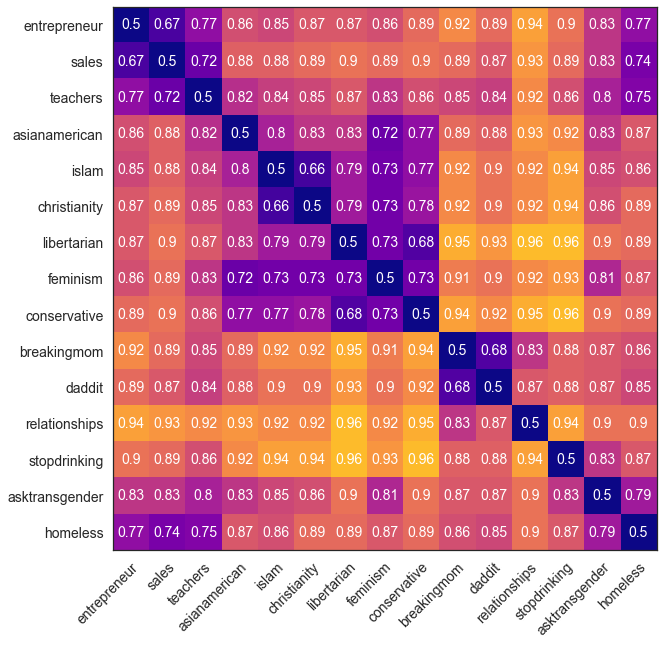

In [74]:
from warpcmap import warp_colormap, wimshow


D = df2.values
D = np.array(D, dtype=float)
D = np.round(D, 2)
identities = list(map(str.lower, columnsTitles))

fig, ax = plt.subplots(figsize=(10, 10))
im = wimshow(D, vmin=0.5, vmax=1, vmid=0.85, beta=0.2, cmap='plasma')

ax.set_xticks(np.arange(len(identities)))
ax.set_yticks(np.arange(len(identities)))
ax.set_xticklabels(identities,fontsize=14)
ax.set_yticklabels(identities, fontsize=14)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(identities)):
    for j in range(len(identities)):
        text = ax.text(j, i, D[i, j],
                       ha="center", va="center", color="white", fontsize=14)

plt.show()

Text(0.5, 1.0, 'Eigenvalues')

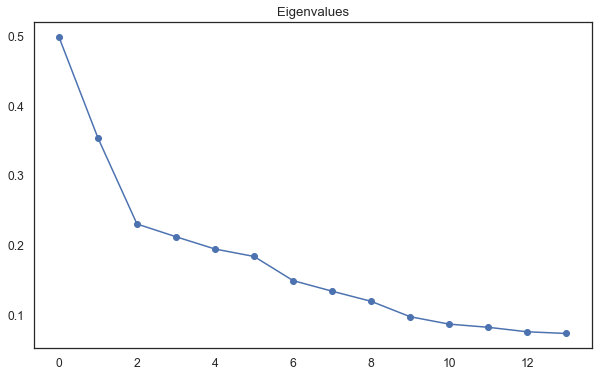

In [75]:
X, evals = mds(D, Q=2)
plt.plot(evals, 'o-')
plt.title('Eigenvalues')

In [76]:
evals

array([0.49960466, 0.35445016, 0.23099971, 0.21265641, 0.19502086,
       0.18435622, 0.14967922, 0.13446987, 0.11992282, 0.09781246,
       0.08717038, 0.08262003, 0.07617161, 0.07373224])

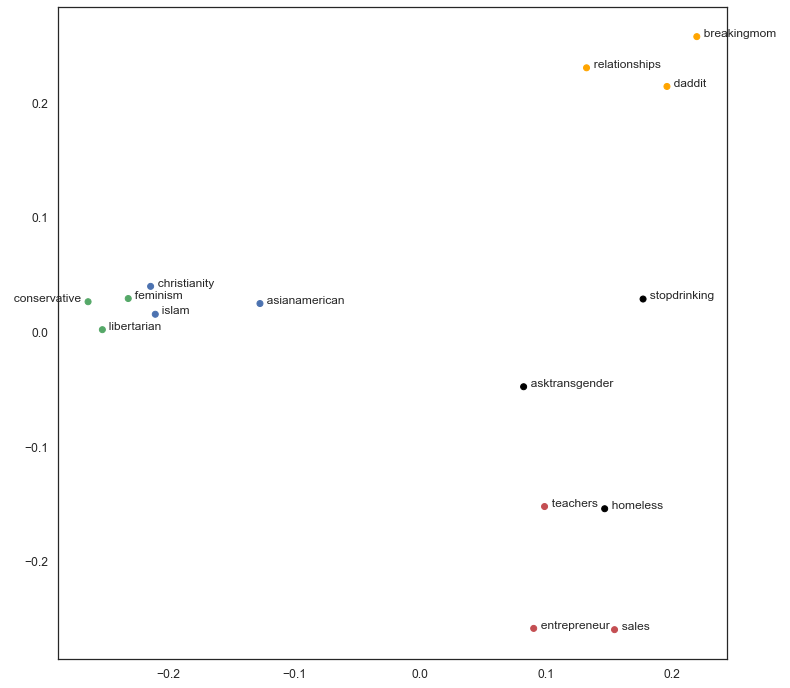

In [77]:
%matplotlib inline

colors = ["r","r","r", "b","b","b", "g","g","g","orange","orange","orange","black","black","black"]
groups = ['vocational', 'ethnic/religious','political', 'relational', 'stigmatised']

plt.figure(figsize=(12, 12))
plt.scatter(*X.T, color=colors)


labels = identities

for i in range(X.shape[0]):
    plt.text(X[i,0], X[i,1], '  %s  ' % labels[i],fontsize=12, 
         ha = 'right'if X[i,0] < -0.26 else 'left',rotation= 0)

plt.show()


## Cluster analysis

### Hierarchical Clustering

In [5]:
def plot_dend(Z, labels):
    plt.ylabel('distance')
    plt.xlabel('groups')
    dendrogram(
        Z,
        p=12,  
        leaf_rotation=90.,
        leaf_font_size=12.,
        labels=labels,
        color_threshold= 0.62
    )
    plt.show()

0.8492465647096131


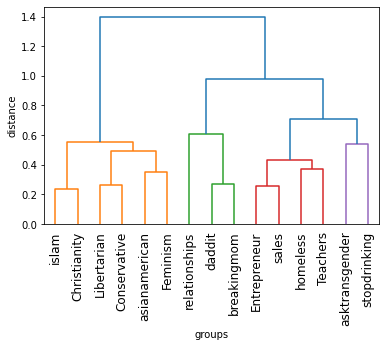

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from collections import defaultdict



Z = linkage(D, 'ward')
c, coph_dists = cophenet(Z, pdist(D))
print(c)
plot_dend(Z, identities)

### K-means Clustering

In [20]:
def contains_all(z, k):
    """True if there is a z[i] = j for all j = 0, ... k-1"""
    for j in range(k):
        if not j in z:
            return False
    return True

def xkmeans(D, k, init=None, Ntrials=1):
    """Perform k-means clustering on the data whose pair-wise distances
    are contained in `D`.  
    
    Parameters:
    -----------
    
    D: array_like, shape (N, N)
        Matrix of pairwise distances between the individuals to be clustered.
        It should therefore be symmetric and elements on the disagonal 
        should be zero. 
        
    k: int
        Number of clusers
        
    init: array_like
        Cluster initialisation method. 
        If not None, it should be an int array of length N  giving the 
        cluster membership of each item to be clustered. 
        If None, initialisation is done at random.
        If an integer, the argument is used as the random number generator 
        seed.
        
    Ntrials: int 
        Number of random starting conditions to try.  Set to 1 if the cluster
        initialisation is supplied. 
    
    Returns
    -------
    centre: numpy array
        Array of length k containing the indices of the cluster centres
        
    membership: 
        Array of length N containing membership of the clustered elements
        
    loss: float
        The sum of the distances to the centres of the clusters.
    """
    N = D.shape[0]
    if hasattr(init, "__array__"):
        Ntrials = 1
    else:
        rng = np.random.default_rng(init)
 
    membership_last = -np.ones(N)   # old memberships for convergence
    ord = np.arange(N, dtype='int')  # For finding absolute indices
    best = dict()
    best['loss'] = np.Inf
    for _ in range(Ntrials):
        if hasattr(init, "__array__"):
            membership = init
        else:
            # Slightly tricky because we need to ensure that every 
            # cluster has at least one member. 
            membership = rng.integers(k, size=N)
            while not contains_all(membership, k):
                for j in range(k):
                    if j not in membership:
                        membership[rng.integers(N)] = j
            

        centre = np.zeros(k, dtype='int')
        while True:
            # Find cluster centres as the minimum summed distance
            # to the elements in that cluster.
            loss = 0
            for j in range(k):
                I = membership == j    # Members of jth cluster
                DD = D[I,:]            # Distances to elements of this cluster
                # Index within cluster of element with min summed distance to other
                # elments in the cluster
                S = DD[:,I].sum(axis=1)
                i = np.argmin(S)
                loss += S[i]
                centre[j] = (ord[I])[i]   # Convert back to D's indices

            #print('Centres:', centre)
            # Find memberships
            membership = np.argmin(D[centre,:], axis=0)
            
            if np.all(membership == membership_last):
                break

            membership_last = membership
        if loss < best['loss']:
            best['loss'] = loss
            best['centre'] = centre
            best['membership'] = membership
        

    return best['centre'], best['membership'], best['loss']


def get_groups(membership, identities):
    """Return the names of the identities indicated by the memberships"""

    G = defaultdict(set)
    for g, id in zip(membership, identities):
            G[g].add(id.lower())
    return G


In [ ]:
D = df2.values
D = np.array(D, dtype=float)

D2 = D - 0.5
D2 = D2*D2

Text(0, 0.5, 'Within-Cluster-Sum of Squared Errors')

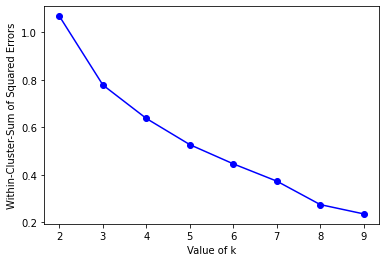

In [36]:

L = []
for k in (ks := list(range(2,10))):
    centres, members, loss = xkmeans(D2, k, Ntrials=100)
    L.append(loss)

    
plt.plot(ks, L, 'bo-')
plt.xlabel('Value of k')
plt.ylabel('Within-Cluster-Sum of Squared Errors')

In [37]:
import scipy.spatial
from pprint import pprint

centres, members, loss = xkmeans(D2, 5, Ntrials=100, init=0)
pprint(get_groups(members, columnsTitles))
print(f'{loss = :.3g}')

defaultdict(<class 'set'>,
            {0: {'homeless', 'entrepreneur', 'sales', 'teachers'},
             1: {'stopdrinking'},
             2: {'asktransgender'},
             3: {'breakingmom', 'daddit', 'relationships'},
             4: {'asianamerican',
                 'christianity',
                 'conservative',
                 'feminism',
                 'islam',
                 'libertarian'}})
loss = 0.538


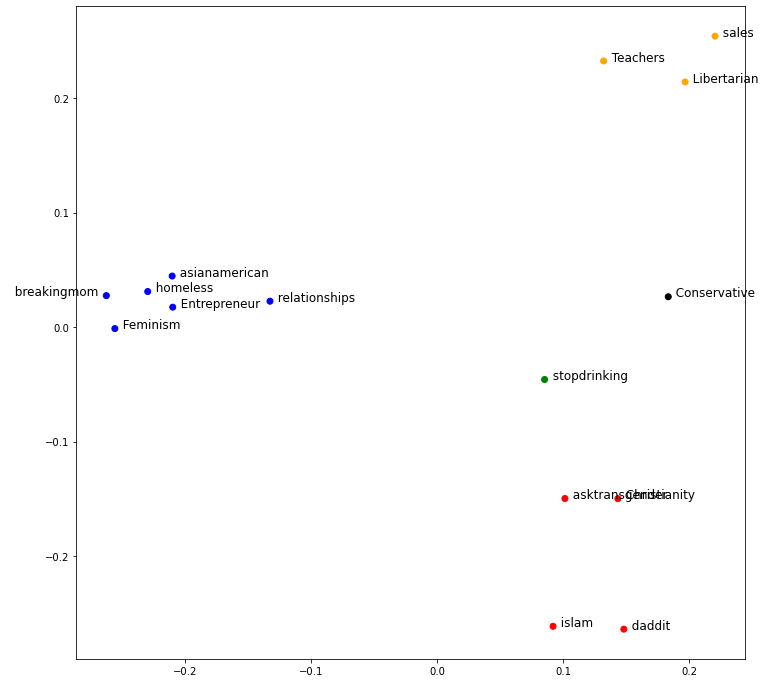

In [38]:
%matplotlib inline
from mds import mds


X, evals = mds(D, Q=2)

colors = ["r","r","r", "b","b","b", "b","b","b","orange","orange","orange","black","green","r"]
groups = ['vocational', 'ethnic/religious','political', 'relational', 'stigmatised']

plt.figure(figsize=(12, 12))
plt.scatter(*X.T, color=colors)


labels = identities

for i in range(X.shape[0]):
    plt.text(X[i,0], X[i,1], '  %s  ' % labels[i],fontsize=12, 
         ha = 'right'if X[i,0] < -0.26 else 'left',rotation= 0)

plt.show()

## Study 2 - Finding out the meaning of the axes

For the next step, we extract the co-ordinates of the identities on the MDS plot. The code below will give us a new dataframe with the MDS co-ordinates of the 15 identities/forums.

In [8]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [80]:
mdsdf = pd.DataFrame(columns=['dimension1','dimension2'])

unzipped = zip(*X)
unzipped= (list(unzipped))

mdsdf['dimension1'] = unzipped[0]
mdsdf['dimension2'] = unzipped[1]
mdsdf['Forum']=identities

In [81]:
mdsdf

,dimension1,dimension2,Forum
0,0.090424,-0.258597,entrepreneur
1,0.154689,-0.259687,sales
2,0.099065,-0.152178,teachers
3,-0.127153,0.025093,asianamerican
4,-0.210367,0.015724,islam
5,-0.214089,0.040081,christianity
6,-0.252434,0.002277,libertarian
7,-0.231871,0.029458,feminism
8,-0.263794,0.026684,conservative
9,0.220087,0.258165,breakingmom


Next, we must run the linguistic data through the values LIWC dictionary found at: https://osf.io/vt8nf. 

This will give a csvfile with each Reddit post and its percentage score for each of the 10 Schwarz values. 



In [81]:
valuesdf = pd.read_csv ('values_dataset.csv')

We then calculate the mean of each value per subreddit and rename the data so that it is more accessible.

In [108]:
mean = valuesdf.groupby('subreddit').mean().reset_index()
mean.rename(columns={'subreddit':'Forum','Values_SE':'security', 'Values_CO':'conformity', 'Values_TR':'tradition', 'Values_BE':'benevolence',
       'Values_UN':'universalism', 'Values_SD':'self-direction', 'Values_ST':'stimulation', 'Values_HE':'hedonism', 'Values_AC':'achievement',
       'Values_PO':'power' }, inplace=True)
mean.drop(['Unnamed: 0', 'Segment'], axis=1, inplace=True)
mean.Forum = mean['Forum'].str.lower()
mean=mean.reindex([2,13,5,6,11,0,4,3,1,8,9,12,14,7,10])

In [109]:
vd = mean.drop(['Forum'], axis=1)
vds = vd.values

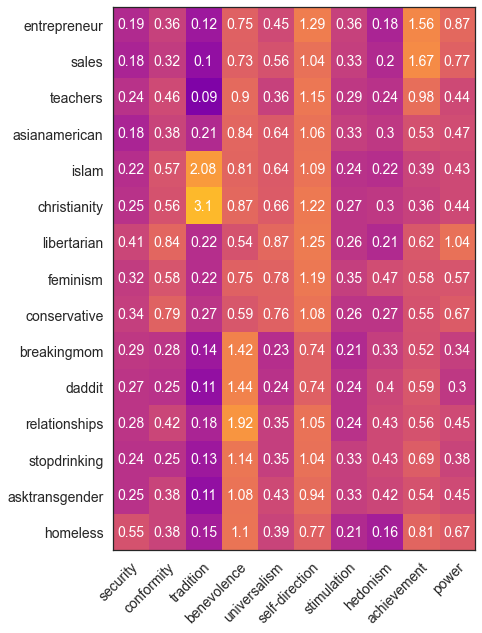

In [143]:
fig, ax = plt.subplots(figsize=(10, 10))


vds = np.array(vds, dtype=float)
vds = np.round(vds, 2)
im = wimshow(vds, vmin=0.05, vmax=6, vmid=0.4, cmap='plasma')

ax.set_xticks(np.arange(len(vd.columns.values)))
ax.set_yticks(np.arange(len(mean.Forum.values)))
ax.set_xticklabels(vd.columns.values,fontsize=14)
ax.set_yticklabels(mean.Forum.values, fontsize=14)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(mean.Forum.values)):
    for j in range(len(vd.columns.values)):
        text = ax.text(j, i, vds[i, j],
                       ha="center", va="center", color="white", fontsize=14)

plt.show()


Next we add the MDS co-ordinates to the datafile. 

In [91]:
values_mdscoords = pd.merge(mean, mdsdf, on='Forum')

In [92]:
values_mdscoords.Forum.unique()

array(['christianity', 'conservative', 'entrepreneur', 'feminism',
       'libertarian', 'teachers', 'asianamerican', 'asktransgender',
       'breakingmom', 'daddit', 'homeless', 'islam', 'relationships',
       'sales', 'stopdrinking'], dtype=object)

In [96]:
values = ['achievement','benevolence','conformity','hedonism','power','self-direction','security','stimulation','tradition','universalism']
X = values_mdscoords[['dimension1', 'dimension2']]
for v in values:
    X2 = sm.add_constant(X)
    est = sm.OLS(values_mdscoords[v], X2)
    est2 = est.fit()
    print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            achievement   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     13.30
Date:                Thu, 14 Jul 2022   Prob (F-statistic):           0.000902
Time:                        11:59:49   Log-Likelihood:                 2.0632
No. Observations:                  15   AIC:                             1.874
Df Residuals:                      12   BIC:                             3.998
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7305      0.061     11.999      0.0

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  w

## Study 3

For study 3, we collected 9 years worth of Reddit data from the asktransgender subreddit. 

In [9]:
asktrans = pd.read_csv('anon_asktransgener_data.csv')

In [10]:
def split_years(df):
    return [df[df['year'] == y] for y in df['year'].unique()]

In [11]:
trans_data = split_years(asktrans)
for t in trans_data:
    t.drop_duplicates('body2', inplace=True)
    print(t.year.unique(), len(t))

<ipython-input-11-f93cace47a3d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.drop_duplicates('body2', inplace=True)


[2015] 148994
[2016] 181917
[2011] 15547
[2014] 83892
[2013] 51323
[2012] 31636
[2018] 206702
[2017] 199096
[2010] 582
[2019] 176513


In [14]:
del trans_data[8]

In [21]:
trans_pairwise={}
forums = cleancomments.subreddit.unique()


for t in trans_data: 
    transtrain, transtest = get_train_test(t)
    for i in range(len(forums)):  
        other_id_train = trainset.loc[trainset['subreddit']==forums[i]]
        other_id_test = testset.loc[testset['subreddit']==forums[i]]
        commentlength = shortest_df_size (other_id_train, transtrain)
        name = str(t.year.unique()) + ' ' + str(forums[i])
        trans_pairwise.setdefault(name, [])
        test1, test2, train1, train2 = get_forum_sample(commentlength, other_id_train, transtrain[allstyle], other_id_test, transtest[allstyle], 6)
        auc, acc = run_classifier(test1, test2, train1, train2)
        trans_pairwise[name].append(auc)
        print(trans_pairwise)
        

27247
27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.769 (+/-0.005)
ExtraTrees for roc_auc
0.848 (+/-0.005)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.78      0.77     27247
         1.0       0.78      0.77      0.77     27247

    accuracy                           0.77     54494
   macro avg       0.77      0.77      0.77     54494
weighted avg       0.77      0.77      0.77     54494


ExtraTrees  AUC 0.853317   Accuracy 0.772452
{'[2015] islam': [0.8533166616875156]}
8694


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694
ExtraTrees for accuracy
0.777 (+/-0.009)
ExtraTrees for roc_auc
0.855 (+/-0.007)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77      8694
         1.0       0.76      0.81      0.79      8694

    accuracy                           0.78     17388
   macro avg       0.78      0.78      0.78     17388
weighted avg       0.78      0.78      0.78     17388


ExtraTrees  AUC 0.85995   Accuracy 0.779676
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302]}
74497
74497 74497 74497 74497
train1= 74497 train2= 74497 test1= 74497 test2=  74497


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.539 (+/-0.003)
ExtraTrees for roc_auc
0.559 (+/-0.004)
(148994, 41)
              precision    recall  f1-score   support

         0.0       0.54      0.53      0.53     74497
         1.0       0.54      0.55      0.54     74497

    accuracy                           0.54    148994
   macro avg       0.54      0.54      0.54    148994
weighted avg       0.54      0.54      0.54    148994


ExtraTrees  AUC 0.558685   Accuracy 0.537236
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638]}
51691
51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.822 (+/-0.006)
ExtraTrees for roc_auc
0.894 (+/-0.005)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.80      0.82     51691
         1.0       0.81      0.84      0.82     51691

    accuracy                           0.82    103382
   macro avg       0.82      0.82      0.82    103382
weighted avg       0.82      0.82      0.82    103382


ExtraTrees  AUC 0.892182   Accuracy 0.820675
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247]}
45507
45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.744 (+/-0.006)
ExtraTrees for roc_auc
0.822 (+/-0.005)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75     45507
         1.0       0.75      0.73      0.74     45507

    accuracy                           0.74     91014
   macro avg       0.74      0.74      0.74     91014
weighted avg       0.74      0.74      0.74     91014


ExtraTrees  AUC 0.822021   Accuracy 0.742996
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189]}
8759


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759
ExtraTrees for accuracy
0.747 (+/-0.011)
ExtraTrees for roc_auc
0.822 (+/-0.013)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75      8759
         1.0       0.75      0.76      0.75      8759

    accuracy                           0.75     17518
   macro avg       0.75      0.75      0.75     17518
weighted avg       0.75      0.75      0.75     17518


ExtraTrees  AUC 0.828291   Accuracy 0.751341
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999]}
7693
7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.739 (+/-0.012)
ExtraTrees for roc_auc
0.810 (+/-0.010)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75      7693
         1.0       0.76      0.72      0.74      7693

    accuracy                           0.74     15386
   macro avg       0.74      0.74      0.74     15386
weighted avg       0.74      0.74      0.74     15386


ExtraTrees  AUC 0.817619   Accuracy 0.742363
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504]}
3874
3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.711 (+/-0.030)
ExtraTrees for roc_auc
0.782 (+/-0.025)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.72      3874
         1.0       0.72      0.72      0.72      3874

    accuracy                           0.72      7748
   macro avg       0.72      0.72      0.72      7748
weighted avg       0.72      0.72      0.72      7748


ExtraTrees  AUC 0.794203   Accuracy 0.717605
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811]}
43661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


43661 43661 43661 43661
train1= 43661 train2= 43661 test1= 43661 test2=  43661
ExtraTrees for accuracy
0.778 (+/-0.005)
ExtraTrees for roc_auc
0.854 (+/-0.004)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.77      0.77     43661
         1.0       0.77      0.79      0.78     43661

    accuracy                           0.78     87322
   macro avg       0.78      0.78      0.78     87322
weighted avg       0.78      0.78      0.78     87322


ExtraTrees  AUC 0.856235   Accuracy 0.776746
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236]}
12628


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628
ExtraTrees for accuracy
0.741 (+/-0.008)
ExtraTrees for roc_auc
0.819 (+/-0.009)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.75      0.74     12628
         1.0       0.75      0.73      0.74     12628

    accuracy                           0.74     25256
   macro avg       0.74      0.74      0.74     25256
weighted avg       0.74      0.74      0.74     25256


ExtraTrees  AUC 0.820526   Accuracy 0.742041
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864]}
74497
74497 74497 74497 74497
t

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.822 (+/-0.002)
ExtraTrees for roc_auc
0.901 (+/-0.002)
(148994, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83     74497
         1.0       0.84      0.80      0.82     74497

    accuracy                           0.82    148994
   macro avg       0.83      0.82      0.82    148994
weighted avg       0.83      0.82      0.82    148994


ExtraTrees  AUC 0.902468   Accuracy 0.824396
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392]}
49398
49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.715 (+/-0.004)
ExtraTrees for roc_auc
0.788 (+/-0.003)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72     49398
         1.0       0.72      0.71      0.71     49398

    accuracy                           0.71     98796
   macro avg       0.71      0.71      0.71     98796
weighted avg       0.71      0.71      0.71     98796


ExtraTrees  AUC 0.788118   Accuracy 0.714918
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631]}
67383
67383 67383 67383 6

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.825 (+/-0.006)
ExtraTrees for roc_auc
0.903 (+/-0.004)
(134766, 41)
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83     67383
         1.0       0.84      0.81      0.82     67383

    accuracy                           0.83    134766
   macro avg       0.83      0.83      0.83    134766
weighted avg       0.83      0.83      0.83    134766


ExtraTrees  AUC 0.904005   Accuracy 0.826254
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.750 (+/-0.003)
ExtraTrees for roc_auc
0.828 (+/-0.003)
(148994, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75     74497
         1.0       0.76      0.73      0.74     74497

    accuracy                           0.75    148994
   macro avg       0.75      0.75      0.75    148994
weighted avg       0.75      0.75      0.75    148994


ExtraTrees  AUC 0.828031   Accuracy 0.748574
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


74497 74497 74497 74497
train1= 74497 train2= 74497 test1= 74497 test2=  74497
ExtraTrees for accuracy
0.780 (+/-0.006)
ExtraTrees for roc_auc
0.862 (+/-0.004)
(148994, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78     74497
         1.0       0.78      0.78      0.78     74497

    accuracy                           0.78    148994
   macro avg       0.78      0.78      0.78    148994
weighted avg       0.78      0.78      0.78    148994


ExtraTrees  AUC 0.862143   Accuracy 0.782193
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247
ExtraTrees for accuracy
0.768 (+/-0.007)
ExtraTrees for roc_auc
0.850 (+/-0.008)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.78      0.77     27247
         1.0       0.78      0.76      0.77     27247

    accuracy                           0.77     54494
   macro avg       0.77      0.77      0.77     54494
weighted avg       0.77      0.77      0.77     54494


ExtraTrees  AUC 0.853671   Accuracy 0.77181
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694
ExtraTrees for accuracy
0.775 (+/-0.007)
ExtraTrees for roc_auc
0.856 (+/-0.007)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77      8694
         1.0       0.76      0.80      0.78      8694

    accuracy                           0.78     17388
   macro avg       0.78      0.78      0.78     17388
weighted avg       0.78      0.78      0.78     17388


ExtraTrees  AUC 0.85578   Accuracy 0.77519
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


90958 90958 90958 90958
train1= 90958 train2= 90958 test1= 90958 test2=  90958
ExtraTrees for accuracy
0.536 (+/-0.006)
ExtraTrees for roc_auc
0.555 (+/-0.008)
(181916, 41)
              precision    recall  f1-score   support

         0.0       0.54      0.54      0.54     90958
         1.0       0.54      0.53      0.53     90958

    accuracy                           0.54    181916
   macro avg       0.54      0.54      0.54    181916
weighted avg       0.54      0.54      0.54    181916


ExtraTrees  AUC 0.555027   Accuracy 0.535637
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691
ExtraTrees for accuracy
0.823 (+/-0.005)
ExtraTrees for roc_auc
0.896 (+/-0.003)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82     51691
         1.0       0.81      0.84      0.83     51691

    accuracy                           0.82    103382
   macro avg       0.82      0.82      0.82    103382
weighted avg       0.82      0.82      0.82    103382


ExtraTrees  AUC 0.894641   Accuracy 0.824244
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.738 (+/-0.006)
ExtraTrees for roc_auc
0.816 (+/-0.007)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74     45507
         1.0       0.75      0.72      0.73     45507

    accuracy                           0.74     91014
   macro avg       0.74      0.74      0.74     91014
weighted avg       0.74      0.74      0.74     91014


ExtraTrees  AUC 0.815513   Accuracy 0.736425
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759
ExtraTrees for accuracy
0.748 (+/-0.010)
ExtraTrees for roc_auc
0.825 (+/-0.015)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75      8759
         1.0       0.75      0.77      0.76      8759

    accuracy                           0.76     17518
   macro avg       0.76      0.76      0.76     17518
weighted avg       0.76      0.76      0.76     17518


ExtraTrees  AUC 0.83049   Accuracy 0.755737
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468019563539

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.743 (+/-0.020)
ExtraTrees for roc_auc
0.813 (+/-0.018)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76      7693
         1.0       0.77      0.73      0.75      7693

    accuracy                           0.75     15386
   macro avg       0.75      0.75      0.75     15386
weighted avg       0.75      0.75      0.75     15386


ExtraTrees  AUC 0.823017   Accuracy 0.753412
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.706 (+/-0.016)
ExtraTrees for roc_auc
0.778 (+/-0.021)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71      3874
         1.0       0.71      0.71      0.71      3874

    accuracy                           0.71      7748
   macro avg       0.71      0.71      0.71      7748
weighted avg       0.71      0.71      0.71      7748


ExtraTrees  AUC 0.789423   Accuracy 0.710506
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.775 (+/-0.007)
ExtraTrees for roc_auc
0.853 (+/-0.005)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77     43661
         1.0       0.77      0.79      0.78     43661

    accuracy                           0.78     87322
   macro avg       0.78      0.78      0.78     87322
weighted avg       0.78      0.78      0.78     87322


ExtraTrees  AUC 0.854636   Accuracy 0.776299
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628
ExtraTrees for accuracy
0.736 (+/-0.010)
ExtraTrees for roc_auc
0.813 (+/-0.005)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74     12628
         1.0       0.74      0.73      0.74     12628

    accuracy                           0.74     25256
   macro avg       0.74      0.74      0.74     25256
weighted avg       0.74      0.74      0.74     25256


ExtraTrees  AUC 0.814755   Accuracy 0.739705
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


90958 90958 90958 90958
train1= 90958 train2= 90958 test1= 90958 test2=  90958
ExtraTrees for accuracy
0.821 (+/-0.004)
ExtraTrees for roc_auc
0.899 (+/-0.002)
(181916, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83     90958
         1.0       0.84      0.79      0.82     90958

    accuracy                           0.82    181916
   macro avg       0.82      0.82      0.82    181916
weighted avg       0.82      0.82      0.82    181916


ExtraTrees  AUC 0.900883   Accuracy 0.82321
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398
ExtraTrees for accuracy
0.710 (+/-0.003)
ExtraTrees for roc_auc
0.784 (+/-0.003)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71     49398
         1.0       0.71      0.70      0.71     49398

    accuracy                           0.71     98796
   macro avg       0.71      0.71      0.71     98796
weighted avg       0.71      0.71      0.71     98796


ExtraTrees  AUC 0.781371   Accuracy 0.708683
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.825 (+/-0.005)
ExtraTrees for roc_auc
0.901 (+/-0.003)
(134766, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83     67383
         1.0       0.84      0.81      0.82     67383

    accuracy                           0.82    134766
   macro avg       0.83      0.82      0.82    134766
weighted avg       0.83      0.82      0.82    134766


ExtraTrees  AUC 0.901266   Accuracy 0.824956
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.741 (+/-0.004)
ExtraTrees for roc_auc
0.820 (+/-0.004)
(181916, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75     90958
         1.0       0.75      0.73      0.74     90958

    accuracy                           0.74    181916
   macro avg       0.74      0.74      0.74    181916
weighted avg       0.74      0.74      0.74    181916


ExtraTrees  AUC 0.819812   Accuracy 0.742678
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.783 (+/-0.004)
ExtraTrees for roc_auc
0.864 (+/-0.003)
(181916, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78     90958
         1.0       0.79      0.77      0.78     90958

    accuracy                           0.78    181916
   macro avg       0.78      0.78      0.78    181916
weighted avg       0.78      0.78      0.78    181916


ExtraTrees  AUC 0.863148   Accuracy 0.782713
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.755 (+/-0.013)
ExtraTrees for roc_auc
0.832 (+/-0.015)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.76      7773
         1.0       0.76      0.75      0.76      7773

    accuracy                           0.76     15546
   macro avg       0.76      0.76      0.76     15546
weighted avg       0.76      0.76      0.76     15546


ExtraTrees  AUC 0.840846   Accuracy 0.757751
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.795 (+/-0.012)
ExtraTrees for roc_auc
0.875 (+/-0.008)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79      7773
         1.0       0.78      0.82      0.80      7773

    accuracy                           0.80     15546
   macro avg       0.80      0.80      0.80     15546
weighted avg       0.80      0.80      0.80     15546


ExtraTrees  AUC 0.876701   Accuracy 0.796025
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.589 (+/-0.016)
ExtraTrees for roc_auc
0.626 (+/-0.017)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59      7773
         1.0       0.59      0.59      0.59      7773

    accuracy                           0.59     15546
   macro avg       0.59      0.59      0.59     15546
weighted avg       0.59      0.59      0.59     15546


ExtraTrees  AUC 0.625064   Accuracy 0.588061
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.827 (+/-0.013)
ExtraTrees for roc_auc
0.899 (+/-0.011)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82      7773
         1.0       0.82      0.83      0.83      7773

    accuracy                           0.82     15546
   macro avg       0.82      0.82      0.82     15546
weighted avg       0.82      0.82      0.82     15546


ExtraTrees  AUC 0.899138   Accuracy 0.824392
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.735 (+/-0.017)
ExtraTrees for roc_auc
0.812 (+/-0.018)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74      7773
         1.0       0.74      0.72      0.73      7773

    accuracy                           0.73     15546
   macro avg       0.73      0.73      0.73     15546
weighted avg       0.73      0.73      0.73     15546


ExtraTrees  AUC 0.808495   Accuracy 0.733372
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.751 (+/-0.017)
ExtraTrees for roc_auc
0.824 (+/-0.010)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75      7773
         1.0       0.75      0.75      0.75      7773

    accuracy                           0.75     15546
   macro avg       0.75      0.75      0.75     15546
weighted avg       0.75      0.75      0.75     15546


ExtraTrees  AUC 0.825233   Accuracy 0.745851
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.739 (+/-0.021)
ExtraTrees for roc_auc
0.810 (+/-0.020)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      7693
         1.0       0.75      0.73      0.74      7693

    accuracy                           0.74     15386
   macro avg       0.74      0.74      0.74     15386
weighted avg       0.74      0.74      0.74     15386


ExtraTrees  AUC 0.817873   Accuracy 0.743208
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.709 (+/-0.013)
ExtraTrees for roc_auc
0.784 (+/-0.009)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72      3874
         1.0       0.72      0.72      0.72      3874

    accuracy                           0.72      7748
   macro avg       0.72      0.72      0.72      7748
weighted avg       0.72      0.72      0.72      7748


ExtraTrees  AUC 0.796497   Accuracy 0.719282
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


7773 7773 7773 7773
train1= 7773 train2= 7773 test1= 7773 test2=  7773
ExtraTrees for accuracy
0.796 (+/-0.008)
ExtraTrees for roc_auc
0.878 (+/-0.007)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80      7773
         1.0       0.79      0.81      0.80      7773

    accuracy                           0.80     15546
   macro avg       0.80      0.80      0.80     15546
weighted avg       0.80      0.80      0.80     15546


ExtraTrees  AUC 0.876076   Accuracy 0.797633
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246801956353

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.739 (+/-0.015)
ExtraTrees for roc_auc
0.818 (+/-0.015)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      7773
         1.0       0.75      0.74      0.74      7773

    accuracy                           0.75     15546
   macro avg       0.75      0.75      0.75     15546
weighted avg       0.75      0.75      0.75     15546


ExtraTrees  AUC 0.822488   Accuracy 0.746173
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.805 (+/-0.017)
ExtraTrees for roc_auc
0.888 (+/-0.013)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      7773
         1.0       0.83      0.79      0.81      7773

    accuracy                           0.81     15546
   macro avg       0.81      0.81      0.81     15546
weighted avg       0.81      0.81      0.81     15546


ExtraTrees  AUC 0.890706   Accuracy 0.811527
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


7773 7773 7773 7773
train1= 7773 train2= 7773 test1= 7773 test2=  7773
ExtraTrees for accuracy
0.715 (+/-0.016)
ExtraTrees for roc_auc
0.785 (+/-0.019)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71      7773
         1.0       0.71      0.71      0.71      7773

    accuracy                           0.71     15546
   macro avg       0.71      0.71      0.71     15546
weighted avg       0.71      0.71      0.71     15546


ExtraTrees  AUC 0.78493   Accuracy 0.713881
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468019563539

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.809 (+/-0.015)
ExtraTrees for roc_auc
0.895 (+/-0.011)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82      7773
         1.0       0.83      0.81      0.82      7773

    accuracy                           0.82     15546
   macro avg       0.82      0.82      0.82     15546
weighted avg       0.82      0.82      0.82     15546


ExtraTrees  AUC 0.898467   Accuracy 0.820661
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.765 (+/-0.014)
ExtraTrees for roc_auc
0.847 (+/-0.014)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77      7773
         1.0       0.77      0.75      0.76      7773

    accuracy                           0.76     15546
   macro avg       0.76      0.76      0.76     15546
weighted avg       0.76      0.76      0.76     15546


ExtraTrees  AUC 0.840071   Accuracy 0.76309
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.767 (+/-0.018)
ExtraTrees for roc_auc
0.847 (+/-0.016)
(15546, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.78      0.78      7773
         1.0       0.78      0.77      0.77      7773

    accuracy                           0.77     15546
   macro avg       0.77      0.77      0.77     15546
weighted avg       0.77      0.77      0.77     15546


ExtraTrees  AUC 0.85259   Accuracy 0.774604
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.779 (+/-0.007)
ExtraTrees for roc_auc
0.859 (+/-0.006)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78     27247
         1.0       0.79      0.77      0.78     27247

    accuracy                           0.78     54494
   macro avg       0.78      0.78      0.78     54494
weighted avg       0.78      0.78      0.78     54494


ExtraTrees  AUC 0.863087   Accuracy 0.781792
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.783 (+/-0.016)
ExtraTrees for roc_auc
0.861 (+/-0.014)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.76      0.77      8694
         1.0       0.77      0.80      0.78      8694

    accuracy                           0.78     17388
   macro avg       0.78      0.78      0.78     17388
weighted avg       0.78      0.78      0.78     17388


ExtraTrees  AUC 0.859148   Accuracy 0.779618
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.547 (+/-0.004)
ExtraTrees for roc_auc
0.570 (+/-0.006)
(83892, 41)
              precision    recall  f1-score   support

         0.0       0.55      0.54      0.54     41946
         1.0       0.55      0.55      0.55     41946

    accuracy                           0.55     83892
   macro avg       0.55      0.55      0.55     83892
weighted avg       0.55      0.55      0.55     83892


ExtraTrees  AUC 0.568637   Accuracy 0.545678
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.825 (+/-0.006)
ExtraTrees for roc_auc
0.897 (+/-0.007)
(83892, 41)
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82     41946
         1.0       0.81      0.84      0.83     41946

    accuracy                           0.82     83892
   macro avg       0.82      0.82      0.82     83892
weighted avg       0.82      0.82      0.82     83892


ExtraTrees  AUC 0.895873   Accuracy 0.823821
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.741 (+/-0.004)
ExtraTrees for roc_auc
0.820 (+/-0.002)
(83892, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75     41946
         1.0       0.75      0.72      0.74     41946

    accuracy                           0.74     83892
   macro avg       0.74      0.74      0.74     83892
weighted avg       0.74      0.74      0.74     83892


ExtraTrees  AUC 0.820065   Accuracy 0.741716
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759
ExtraTrees for accuracy
0.761 (+/-0.011)
ExtraTrees for roc_auc
0.834 (+/-0.011)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76      8759
         1.0       0.75      0.77      0.76      8759

    accuracy                           0.76     17518
   macro avg       0.76      0.76      0.76     17518
weighted avg       0.76      0.76      0.76     17518


ExtraTrees  AUC 0.835397   Accuracy 0.758077
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246801956353

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.753 (+/-0.014)
ExtraTrees for roc_auc
0.828 (+/-0.011)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77      7693
         1.0       0.77      0.74      0.76      7693

    accuracy                           0.76     15386
   macro avg       0.76      0.76      0.76     15386
weighted avg       0.76      0.76      0.76     15386


ExtraTrees  AUC 0.833605   Accuracy 0.760692
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.708 (+/-0.022)
ExtraTrees for roc_auc
0.782 (+/-0.022)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71      3874
         1.0       0.71      0.69      0.70      3874

    accuracy                           0.71      7748
   macro avg       0.71      0.71      0.71      7748
weighted avg       0.71      0.71      0.71      7748


ExtraTrees  AUC 0.780316   Accuracy 0.705472
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.783 (+/-0.005)
ExtraTrees for roc_auc
0.861 (+/-0.004)
(83892, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78     41946
         1.0       0.78      0.79      0.78     41946

    accuracy                           0.78     83892
   macro avg       0.78      0.78      0.78     83892
weighted avg       0.78      0.78      0.78     83892


ExtraTrees  AUC 0.86084   Accuracy 0.78185
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.9

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.737 (+/-0.014)
ExtraTrees for roc_auc
0.816 (+/-0.015)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74     12628
         1.0       0.75      0.72      0.73     12628

    accuracy                           0.74     25256
   macro avg       0.74      0.74      0.74     25256
weighted avg       0.74      0.74      0.74     25256


ExtraTrees  AUC 0.814451   Accuracy 0.737488
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.832 (+/-0.004)
ExtraTrees for roc_auc
0.910 (+/-0.003)
(83892, 41)
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84     41946
         1.0       0.85      0.81      0.83     41946

    accuracy                           0.83     83892
   macro avg       0.84      0.83      0.83     83892
weighted avg       0.84      0.83      0.83     83892


ExtraTrees  AUC 0.909817   Accuracy 0.834156
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.718 (+/-0.004)
ExtraTrees for roc_auc
0.792 (+/-0.006)
(83892, 41)
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72     41946
         1.0       0.72      0.70      0.71     41946

    accuracy                           0.71     83892
   macro avg       0.71      0.71      0.71     83892
weighted avg       0.71      0.71      0.71     83892


ExtraTrees  AUC 0.788305   Accuracy 0.714073
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.835 (+/-0.007)
ExtraTrees for roc_auc
0.912 (+/-0.004)
(83892, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     41946
         1.0       0.85      0.82      0.83     41946

    accuracy                           0.84     83892
   macro avg       0.84      0.84      0.84     83892
weighted avg       0.84      0.84      0.84     83892


ExtraTrees  AUC 0.912398   Accuracy 0.836945
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.744 (+/-0.008)
ExtraTrees for roc_auc
0.820 (+/-0.008)
(83892, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.75      0.75     41946
         1.0       0.75      0.73      0.74     41946

    accuracy                           0.74     83892
   macro avg       0.74      0.74      0.74     83892
weighted avg       0.74      0.74      0.74     83892


ExtraTrees  AUC 0.82144   Accuracy 0.743253
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.789 (+/-0.003)
ExtraTrees for roc_auc
0.870 (+/-0.004)
(83892, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79     41946
         1.0       0.80      0.78      0.79     41946

    accuracy                           0.79     83892
   macro avg       0.79      0.79      0.79     83892
weighted avg       0.79      0.79      0.79     83892


ExtraTrees  AUC 0.870416   Accuracy 0.790457
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.778 (+/-0.004)
ExtraTrees for roc_auc
0.857 (+/-0.002)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78     25661
         1.0       0.78      0.78      0.78     25661

    accuracy                           0.78     51322
   macro avg       0.78      0.78      0.78     51322
weighted avg       0.78      0.78      0.78     51322


ExtraTrees  AUC 0.861137   Accuracy 0.779919
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.780 (+/-0.009)
ExtraTrees for roc_auc
0.859 (+/-0.010)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.78      8694
         1.0       0.77      0.82      0.79      8694

    accuracy                           0.78     17388
   macro avg       0.78      0.78      0.78     17388
weighted avg       0.78      0.78      0.78     17388


ExtraTrees  AUC 0.864886   Accuracy 0.783471
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.559 (+/-0.011)
ExtraTrees for roc_auc
0.587 (+/-0.010)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.56      0.56      0.56     25661
         1.0       0.56      0.56      0.56     25661

    accuracy                           0.56     51322
   macro avg       0.56      0.56      0.56     51322
weighted avg       0.56      0.56      0.56     51322


ExtraTrees  AUC 0.585808   Accuracy 0.556136
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.820 (+/-0.007)
ExtraTrees for roc_auc
0.894 (+/-0.002)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82     25661
         1.0       0.81      0.84      0.83     25661

    accuracy                           0.82     51322
   macro avg       0.83      0.82      0.82     51322
weighted avg       0.83      0.82      0.82     51322


ExtraTrees  AUC 0.896844   Accuracy 0.824909
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


25661 25661 25661 25661
train1= 25661 train2= 25661 test1= 25661 test2=  25661
ExtraTrees for accuracy
0.732 (+/-0.011)
ExtraTrees for roc_auc
0.811 (+/-0.010)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74     25661
         1.0       0.75      0.71      0.73     25661

    accuracy                           0.74     51322
   macro avg       0.74      0.74      0.74     51322
weighted avg       0.74      0.74      0.74     51322


ExtraTrees  AUC 0.812583   Accuracy 0.735864
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.755 (+/-0.013)
ExtraTrees for roc_auc
0.833 (+/-0.015)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76      8759
         1.0       0.76      0.77      0.76      8759

    accuracy                           0.76     17518
   macro avg       0.76      0.76      0.76     17518
weighted avg       0.76      0.76      0.76     17518


ExtraTrees  AUC 0.83899   Accuracy 0.760817
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.757 (+/-0.012)
ExtraTrees for roc_auc
0.832 (+/-0.010)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77      7693
         1.0       0.77      0.75      0.76      7693

    accuracy                           0.76     15386
   macro avg       0.76      0.76      0.76     15386
weighted avg       0.76      0.76      0.76     15386


ExtraTrees  AUC 0.837721   Accuracy 0.763486
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.708 (+/-0.020)
ExtraTrees for roc_auc
0.778 (+/-0.009)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71      3874
         1.0       0.71      0.72      0.71      3874

    accuracy                           0.71      7748
   macro avg       0.71      0.71      0.71      7748
weighted avg       0.71      0.71      0.71      7748


ExtraTrees  AUC 0.789274   Accuracy 0.713474
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.783 (+/-0.005)
ExtraTrees for roc_auc
0.861 (+/-0.004)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78     25661
         1.0       0.78      0.79      0.79     25661

    accuracy                           0.78     51322
   macro avg       0.78      0.78      0.78     51322
weighted avg       0.78      0.78      0.78     51322


ExtraTrees  AUC 0.863666   Accuracy 0.784439
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.732 (+/-0.008)
ExtraTrees for roc_auc
0.812 (+/-0.011)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.75      0.74     12628
         1.0       0.75      0.73      0.74     12628

    accuracy                           0.74     25256
   macro avg       0.74      0.74      0.74     25256
weighted avg       0.74      0.74      0.74     25256


ExtraTrees  AUC 0.8191   Accuracy 0.741646
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.9

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.832 (+/-0.005)
ExtraTrees for roc_auc
0.908 (+/-0.003)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84     25661
         1.0       0.85      0.81      0.83     25661

    accuracy                           0.83     51322
   macro avg       0.83      0.83      0.83     51322
weighted avg       0.83      0.83      0.83     51322


ExtraTrees  AUC 0.909396   Accuracy 0.831671
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.714 (+/-0.004)
ExtraTrees for roc_auc
0.787 (+/-0.003)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72     25661
         1.0       0.72      0.71      0.71     25661

    accuracy                           0.71     51322
   macro avg       0.71      0.71      0.71     51322
weighted avg       0.71      0.71      0.71     51322


ExtraTrees  AUC 0.790285   Accuracy 0.714567
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.834 (+/-0.004)
ExtraTrees for roc_auc
0.911 (+/-0.004)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     25661
         1.0       0.85      0.82      0.83     25661

    accuracy                           0.84     51322
   macro avg       0.84      0.84      0.84     51322
weighted avg       0.84      0.84      0.84     51322


ExtraTrees  AUC 0.913274   Accuracy 0.836893
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.744 (+/-0.007)
ExtraTrees for roc_auc
0.823 (+/-0.002)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75     25661
         1.0       0.75      0.72      0.74     25661

    accuracy                           0.74     51322
   macro avg       0.74      0.74      0.74     51322
weighted avg       0.74      0.74      0.74     51322


ExtraTrees  AUC 0.822526   Accuracy 0.742567
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.789 (+/-0.006)
ExtraTrees for roc_auc
0.870 (+/-0.005)
(51322, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79     25661
         1.0       0.79      0.79      0.79     25661

    accuracy                           0.79     51322
   macro avg       0.79      0.79      0.79     51322
weighted avg       0.79      0.79      0.79     51322


ExtraTrees  AUC 0.870434   Accuracy 0.792097
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.776 (+/-0.016)
ExtraTrees for roc_auc
0.855 (+/-0.012)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78     15818
         1.0       0.78      0.78      0.78     15818

    accuracy                           0.78     31636
   macro avg       0.78      0.78      0.78     31636
weighted avg       0.78      0.78      0.78     31636


ExtraTrees  AUC 0.860015   Accuracy 0.779587
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.783 (+/-0.009)
ExtraTrees for roc_auc
0.866 (+/-0.007)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.78      8694
         1.0       0.77      0.82      0.79      8694

    accuracy                           0.78     17388
   macro avg       0.79      0.78      0.78     17388
weighted avg       0.79      0.78      0.78     17388


ExtraTrees  AUC 0.866866   Accuracy 0.784679
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.565 (+/-0.008)
ExtraTrees for roc_auc
0.597 (+/-0.008)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57     15818
         1.0       0.57      0.57      0.57     15818

    accuracy                           0.57     31636
   macro avg       0.57      0.57      0.57     31636
weighted avg       0.57      0.57      0.57     31636


ExtraTrees  AUC 0.60584   Accuracy 0.569889
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.817 (+/-0.007)
ExtraTrees for roc_auc
0.893 (+/-0.006)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82     15818
         1.0       0.81      0.84      0.82     15818

    accuracy                           0.82     31636
   macro avg       0.82      0.82      0.82     31636
weighted avg       0.82      0.82      0.82     31636


ExtraTrees  AUC 0.893483   Accuracy 0.822512
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.734 (+/-0.011)
ExtraTrees for roc_auc
0.810 (+/-0.012)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.75      0.74     15818
         1.0       0.74      0.71      0.73     15818

    accuracy                           0.73     31636
   macro avg       0.73      0.73      0.73     31636
weighted avg       0.73      0.73      0.73     31636


ExtraTrees  AUC 0.808805   Accuracy 0.732804
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.761 (+/-0.014)
ExtraTrees for roc_auc
0.838 (+/-0.009)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.76      0.76      8759
         1.0       0.76      0.78      0.77      8759

    accuracy                           0.77     17518
   macro avg       0.77      0.77      0.77     17518
weighted avg       0.77      0.77      0.77     17518


ExtraTrees  AUC 0.843861   Accuracy 0.766697
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.755 (+/-0.017)
ExtraTrees for roc_auc
0.833 (+/-0.017)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77      7693
         1.0       0.77      0.75      0.76      7693

    accuracy                           0.76     15386
   macro avg       0.76      0.76      0.76     15386
weighted avg       0.76      0.76      0.76     15386


ExtraTrees  AUC 0.84095   Accuracy 0.762641
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.700 (+/-0.031)
ExtraTrees for roc_auc
0.775 (+/-0.026)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.71      3874
         1.0       0.71      0.70      0.70      3874

    accuracy                           0.71      7748
   macro avg       0.71      0.71      0.71      7748
weighted avg       0.71      0.71      0.71      7748


ExtraTrees  AUC 0.780309   Accuracy 0.70586
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.9

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


15818 15818 15818 15818
train1= 15818 train2= 15818 test1= 15818 test2=  15818
ExtraTrees for accuracy
0.784 (+/-0.010)
ExtraTrees for roc_auc
0.864 (+/-0.009)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79     15818
         1.0       0.78      0.80      0.79     15818

    accuracy                           0.79     31636
   macro avg       0.79      0.79      0.79     31636
weighted avg       0.79      0.79      0.79     31636


ExtraTrees  AUC 0.867102   Accuracy 0.787742
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.734 (+/-0.005)
ExtraTrees for roc_auc
0.811 (+/-0.009)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74     12628
         1.0       0.74      0.72      0.73     12628

    accuracy                           0.73     25256
   macro avg       0.73      0.73      0.73     25256
weighted avg       0.73      0.73      0.73     25256


ExtraTrees  AUC 0.814763   Accuracy 0.734083
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.829 (+/-0.013)
ExtraTrees for roc_auc
0.908 (+/-0.009)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83     15818
         1.0       0.85      0.81      0.83     15818

    accuracy                           0.83     31636
   macro avg       0.83      0.83      0.83     31636
weighted avg       0.83      0.83      0.83     31636


ExtraTrees  AUC 0.90929   Accuracy 0.831268
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


15818 15818 15818 15818
train1= 15818 train2= 15818 test1= 15818 test2=  15818
ExtraTrees for accuracy
0.713 (+/-0.012)
ExtraTrees for roc_auc
0.789 (+/-0.012)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72     15818
         1.0       0.72      0.72      0.72     15818

    accuracy                           0.72     31636
   macro avg       0.72      0.72      0.72     31636
weighted avg       0.72      0.72      0.72     31636


ExtraTrees  AUC 0.790838   Accuracy 0.716399
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.831 (+/-0.010)
ExtraTrees for roc_auc
0.910 (+/-0.008)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     15818
         1.0       0.84      0.82      0.83     15818

    accuracy                           0.84     31636
   macro avg       0.84      0.84      0.84     31636
weighted avg       0.84      0.84      0.84     31636


ExtraTrees  AUC 0.912774   Accuracy 0.835125
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.748 (+/-0.009)
ExtraTrees for roc_auc
0.827 (+/-0.006)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75     15818
         1.0       0.76      0.73      0.74     15818

    accuracy                           0.75     31636
   macro avg       0.75      0.75      0.75     31636
weighted avg       0.75      0.75      0.75     31636


ExtraTrees  AUC 0.829303   Accuracy 0.748072
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.787 (+/-0.008)
ExtraTrees for roc_auc
0.868 (+/-0.010)
(31636, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79     15818
         1.0       0.79      0.79      0.79     15818

    accuracy                           0.79     31636
   macro avg       0.79      0.79      0.79     31636
weighted avg       0.79      0.79      0.79     31636


ExtraTrees  AUC 0.869978   Accuracy 0.79144
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247
ExtraTrees for accuracy
0.765 (+/-0.008)
ExtraTrees for roc_auc
0.847 (+/-0.008)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77     27247
         1.0       0.77      0.76      0.77     27247

    accuracy                           0.77     54494
   macro avg       0.77      0.77      0.77     54494
weighted avg       0.77      0.77      0.77     54494


ExtraTrees  AUC 0.850624   Accuracy 0.768562
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.781 (+/-0.014)
ExtraTrees for roc_auc
0.865 (+/-0.011)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78      8694
         1.0       0.78      0.81      0.79      8694

    accuracy                           0.79     17388
   macro avg       0.79      0.79      0.79     17388
weighted avg       0.79      0.79      0.79     17388


ExtraTrees  AUC 0.869855   Accuracy 0.78813
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


103351 103351 103351 103351
train1= 103351 train2= 103351 test1= 103351 test2=  103351
ExtraTrees for accuracy
0.326 (+/-0.003)
ExtraTrees for roc_auc
0.213 (+/-0.004)
(206702, 41)
              precision    recall  f1-score   support

         0.0       0.29      0.30      0.29    103351
         1.0       0.27      0.26      0.27    103351

    accuracy                           0.28    206702
   macro avg       0.28      0.28      0.28    206702
weighted avg       0.28      0.28      0.28    206702


ExtraTrees  AUC 0.15686   Accuracy 0.278744
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691
ExtraTrees for accuracy
0.828 (+/-0.007)
ExtraTrees for roc_auc
0.899 (+/-0.004)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83     51691
         1.0       0.82      0.84      0.83     51691

    accuracy                           0.83    103382
   macro avg       0.83      0.83      0.83    103382
weighted avg       0.83      0.83      0.83    103382


ExtraTrees  AUC 0.898724   Accuracy 0.828645
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507
ExtraTrees for accuracy
0.748 (+/-0.005)
ExtraTrees for roc_auc
0.826 (+/-0.004)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75     45507
         1.0       0.76      0.73      0.74     45507

    accuracy                           0.75     91014
   macro avg       0.75      0.75      0.75     91014
weighted avg       0.75      0.75      0.75     91014


ExtraTrees  AUC 0.826909   Accuracy 0.747852
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759
ExtraTrees for accuracy
0.749 (+/-0.009)
ExtraTrees for roc_auc
0.827 (+/-0.005)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76      8759
         1.0       0.75      0.76      0.76      8759

    accuracy                           0.76     17518
   macro avg       0.76      0.76      0.76     17518
weighted avg       0.76      0.76      0.76     17518


ExtraTrees  AUC 0.83239   Accuracy 0.757107
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468019563539

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693
ExtraTrees for accuracy
0.738 (+/-0.017)
ExtraTrees for roc_auc
0.812 (+/-0.019)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75      7693
         1.0       0.76      0.72      0.74      7693

    accuracy                           0.75     15386
   macro avg       0.75      0.75      0.75     15386
weighted avg       0.75      0.75      0.75     15386


ExtraTrees  AUC 0.817049   Accuracy 0.745548
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246801956353

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


3874 3874 3874 3874
train1= 3874 train2= 3874 test1= 3874 test2=  3874
ExtraTrees for accuracy
0.719 (+/-0.013)
ExtraTrees for roc_auc
0.790 (+/-0.016)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72      3874
         1.0       0.72      0.73      0.72      3874

    accuracy                           0.72      7748
   macro avg       0.72      0.72      0.72      7748
weighted avg       0.72      0.72      0.72      7748


ExtraTrees  AUC 0.802453   Accuracy 0.723154
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468019563539

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.787 (+/-0.005)
ExtraTrees for roc_auc
0.867 (+/-0.004)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79     43661
         1.0       0.78      0.80      0.79     43661

    accuracy                           0.79     87322
   macro avg       0.79      0.79      0.79     87322
weighted avg       0.79      0.79      0.79     87322


ExtraTrees  AUC 0.869769   Accuracy 0.789492
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.748 (+/-0.012)
ExtraTrees for roc_auc
0.828 (+/-0.011)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75     12628
         1.0       0.75      0.73      0.74     12628

    accuracy                           0.75     25256
   macro avg       0.75      0.75      0.75     25256
weighted avg       0.75      0.75      0.75     25256


ExtraTrees  AUC 0.827278   Accuracy 0.746714
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


103351 103351 103351 103351
train1= 103351 train2= 103351 test1= 103351 test2=  103351
ExtraTrees for accuracy
0.822 (+/-0.003)
ExtraTrees for roc_auc
0.901 (+/-0.001)
(206702, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83    103351
         1.0       0.84      0.79      0.82    103351

    accuracy                           0.82    206702
   macro avg       0.82      0.82      0.82    206702
weighted avg       0.82      0.82      0.82    206702


ExtraTrees  AUC 0.901653   Accuracy 0.822933
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398
ExtraTrees for accuracy
0.720 (+/-0.007)
ExtraTrees for roc_auc
0.795 (+/-0.006)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.71      0.73      0.72     49398
         1.0       0.73      0.71      0.72     49398

    accuracy                           0.72     98796
   macro avg       0.72      0.72      0.72     98796
weighted avg       0.72      0.72      0.72     98796


ExtraTrees  AUC 0.795718   Accuracy 0.71929
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.826 (+/-0.003)
ExtraTrees for roc_auc
0.904 (+/-0.002)
(134766, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83     67383
         1.0       0.84      0.80      0.82     67383

    accuracy                           0.82    134766
   macro avg       0.83      0.82      0.82    134766
weighted avg       0.83      0.82      0.82    134766


ExtraTrees  AUC 0.902802   Accuracy 0.824511
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


102464 102464 102464 102464
train1= 102464 train2= 102464 test1= 102464 test2=  102464
ExtraTrees for accuracy
0.757 (+/-0.005)
ExtraTrees for roc_auc
0.838 (+/-0.007)
(204928, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.78      0.76    102464
         1.0       0.77      0.74      0.75    102464

    accuracy                           0.76    204928
   macro avg       0.76      0.76      0.76    204928
weighted avg       0.76      0.76      0.76    204928


ExtraTrees  AUC 0.83763   Accuracy 0.756905
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


103351 103351 103351 103351
train1= 103351 train2= 103351 test1= 103351 test2=  103351
ExtraTrees for accuracy
0.782 (+/-0.003)
ExtraTrees for roc_auc
0.863 (+/-0.003)
(206702, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78    103351
         1.0       0.79      0.77      0.78    103351

    accuracy                           0.78    206702
   macro avg       0.78      0.78      0.78    206702
weighted avg       0.78      0.78      0.78    206702


ExtraTrees  AUC 0.86301   Accuracy 0.781105
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247
ExtraTrees for accuracy
0.767 (+/-0.006)
ExtraTrees for roc_auc
0.847 (+/-0.007)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77     27247
         1.0       0.78      0.76      0.77     27247

    accuracy                           0.77     54494
   macro avg       0.77      0.77      0.77     54494
weighted avg       0.77      0.77      0.77     54494


ExtraTrees  AUC 0.850452   Accuracy 0.769718
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694
ExtraTrees for accuracy
0.777 (+/-0.007)
ExtraTrees for roc_auc
0.857 (+/-0.009)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77      8694
         1.0       0.76      0.81      0.79      8694

    accuracy                           0.78     17388
   macro avg       0.78      0.78      0.78     17388
weighted avg       0.78      0.78      0.78     17388


ExtraTrees  AUC 0.86098   Accuracy 0.779561
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468019563539

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.528 (+/-0.005)
ExtraTrees for roc_auc
0.546 (+/-0.006)
(199096, 41)
              precision    recall  f1-score   support

         0.0       0.53      0.53      0.53     99548
         1.0       0.53      0.52      0.53     99548

    accuracy                           0.53    199096
   macro avg       0.53      0.53      0.53    199096
weighted avg       0.53      0.53      0.53    199096


ExtraTrees  AUC 0.546874   Accuracy 0.529016
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691
ExtraTrees for accuracy
0.824 (+/-0.007)
ExtraTrees for roc_auc
0.895 (+/-0.006)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82     51691
         1.0       0.81      0.84      0.83     51691

    accuracy                           0.82    103382
   macro avg       0.82      0.82      0.82    103382
weighted avg       0.82      0.82      0.82    103382


ExtraTrees  AUC 0.895074   Accuracy 0.824438
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.739 (+/-0.003)
ExtraTrees for roc_auc
0.817 (+/-0.003)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75     45507
         1.0       0.75      0.72      0.73     45507

    accuracy                           0.74     91014
   macro avg       0.74      0.74      0.74     91014
weighted avg       0.74      0.74      0.74     91014


ExtraTrees  AUC 0.818605   Accuracy 0.740084
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759
ExtraTrees for accuracy
0.750 (+/-0.008)
ExtraTrees for roc_auc
0.827 (+/-0.002)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75      8759
         1.0       0.75      0.75      0.75      8759

    accuracy                           0.75     17518
   macro avg       0.75      0.75      0.75     17518
weighted avg       0.75      0.75      0.75     17518


ExtraTrees  AUC 0.824472   Accuracy 0.750257
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246801956353

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


7693 7693 7693 7693
train1= 7693 train2= 7693 test1= 7693 test2=  7693
ExtraTrees for accuracy
0.740 (+/-0.010)
ExtraTrees for roc_auc
0.811 (+/-0.012)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.77      0.75      7693
         1.0       0.76      0.70      0.73      7693

    accuracy                           0.74     15386
   macro avg       0.74      0.74      0.74     15386
weighted avg       0.74      0.74      0.74     15386


ExtraTrees  AUC 0.810809   Accuracy 0.738659
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246801956353

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.706 (+/-0.022)
ExtraTrees for roc_auc
0.778 (+/-0.020)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.72      3874
         1.0       0.71      0.72      0.72      3874

    accuracy                           0.72      7748
   macro avg       0.72      0.72      0.72      7748
weighted avg       0.72      0.72      0.72      7748


ExtraTrees  AUC 0.7873   Accuracy 0.71683
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.904

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.779 (+/-0.003)
ExtraTrees for roc_auc
0.856 (+/-0.003)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78     43661
         1.0       0.77      0.79      0.78     43661

    accuracy                           0.78     87322
   macro avg       0.78      0.78      0.78     87322
weighted avg       0.78      0.78      0.78     87322


ExtraTrees  AUC 0.859392   Accuracy 0.780445
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628
ExtraTrees for accuracy
0.737 (+/-0.008)
ExtraTrees for roc_auc
0.814 (+/-0.005)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74     12628
         1.0       0.75      0.72      0.73     12628

    accuracy                           0.74     25256
   macro avg       0.74      0.74      0.74     25256
weighted avg       0.74      0.74      0.74     25256


ExtraTrees  AUC 0.817018   Accuracy 0.738676
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


99548 99548 99548 99548
train1= 99548 train2= 99548 test1= 99548 test2=  99548
ExtraTrees for accuracy
0.819 (+/-0.003)
ExtraTrees for roc_auc
0.897 (+/-0.002)
(199096, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83     99548
         1.0       0.84      0.79      0.81     99548

    accuracy                           0.82    199096
   macro avg       0.82      0.82      0.82    199096
weighted avg       0.82      0.82      0.82    199096


ExtraTrees  AUC 0.89821   Accuracy 0.820097
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


49398 49398 49398 49398
train1= 49398 train2= 49398 test1= 49398 test2=  49398
ExtraTrees for accuracy
0.710 (+/-0.005)
ExtraTrees for roc_auc
0.783 (+/-0.003)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71     49398
         1.0       0.71      0.70      0.71     49398

    accuracy                           0.71     98796
   macro avg       0.71      0.71      0.71     98796
weighted avg       0.71      0.71      0.71     98796


ExtraTrees  AUC 0.783813   Accuracy 0.710919
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


 67383 train2= 67383 test1= 67383 test2=  67383
ExtraTrees for accuracy
0.822 (+/-0.004)
ExtraTrees for roc_auc
0.900 (+/-0.002)
(134766, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83     67383
         1.0       0.84      0.80      0.82     67383

    accuracy                           0.82    134766
   macro avg       0.82      0.82      0.82    134766
weighted avg       0.82      0.82      0.82    134766


ExtraTrees  AUC 0.900069   Accuracy 0.823064
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


99548 99548 99548 99548
train1= 99548 train2= 99548 test1= 99548 test2=  99548
ExtraTrees for accuracy
0.745 (+/-0.004)
ExtraTrees for roc_auc
0.824 (+/-0.005)
(199096, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75     99548
         1.0       0.76      0.73      0.74     99548

    accuracy                           0.75    199096
   macro avg       0.75      0.75      0.75    199096
weighted avg       0.75      0.75      0.75    199096


ExtraTrees  AUC 0.823907   Accuracy 0.745329
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


99548 99548 99548 99548
train1= 99548 train2= 99548 test1= 99548 test2=  99548
ExtraTrees for accuracy
0.778 (+/-0.004)
ExtraTrees for roc_auc
0.860 (+/-0.002)
(199096, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78     99548
         1.0       0.78      0.77      0.78     99548

    accuracy                           0.78    199096
   macro avg       0.78      0.78      0.78    199096
weighted avg       0.78      0.78      0.78    199096


ExtraTrees  AUC 0.86013   Accuracy 0.779142
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


27247 27247 27247 27247
train1= 27247 train2= 27247 test1= 27247 test2=  27247
ExtraTrees for accuracy
0.778 (+/-0.006)
ExtraTrees for roc_auc
0.857 (+/-0.005)
(54494, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78     27247
         1.0       0.78      0.77      0.78     27247

    accuracy                           0.78     54494
   macro avg       0.78      0.78      0.78     54494
weighted avg       0.78      0.78      0.78     54494


ExtraTrees  AUC 0.8599   Accuracy 0.778049
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246801

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8694 8694 8694 8694
train1= 8694 train2= 8694 test1= 8694 test2=  8694
ExtraTrees for accuracy
0.792 (+/-0.011)
ExtraTrees for roc_auc
0.875 (+/-0.010)
(17388, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.79      8694
         1.0       0.78      0.81      0.80      8694

    accuracy                           0.79     17388
   macro avg       0.79      0.79      0.79     17388
weighted avg       0.79      0.79      0.79     17388


ExtraTrees  AUC 0.876532   Accuracy 0.792271
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246801956353

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


88256 88256 88256 88256
train1= 88256 train2= 88256 test1= 88256 test2=  88256
ExtraTrees for accuracy
0.537 (+/-0.006)
ExtraTrees for roc_auc
0.563 (+/-0.004)
(176512, 41)
              precision    recall  f1-score   support

         0.0       0.53      0.61      0.57     88256
         1.0       0.55      0.47      0.50     88256

    accuracy                           0.54    176512
   macro avg       0.54      0.54      0.54    176512
weighted avg       0.54      0.54      0.54    176512


ExtraTrees  AUC 0.56546   Accuracy 0.539051
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


51691 51691 51691 51691
train1= 51691 train2= 51691 test1= 51691 test2=  51691
ExtraTrees for accuracy
0.831 (+/-0.005)
ExtraTrees for roc_auc
0.901 (+/-0.004)
(103382, 41)
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83     51691
         1.0       0.82      0.85      0.83     51691

    accuracy                           0.83    103382
   macro avg       0.83      0.83      0.83    103382
weighted avg       0.83      0.83      0.83    103382


ExtraTrees  AUC 0.901169   Accuracy 0.831673
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


45507 45507 45507 45507
train1= 45507 train2= 45507 test1= 45507 test2=  45507
ExtraTrees for accuracy
0.750 (+/-0.007)
ExtraTrees for roc_auc
0.831 (+/-0.006)
(91014, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76     45507
         1.0       0.77      0.73      0.75     45507

    accuracy                           0.75     91014
   macro avg       0.75      0.75      0.75     91014
weighted avg       0.75      0.75      0.75     91014


ExtraTrees  AUC 0.83345   Accuracy 0.752642
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8759 8759 8759 8759
train1= 8759 train2= 8759 test1= 8759 test2=  8759
ExtraTrees for accuracy
0.765 (+/-0.016)
ExtraTrees for roc_auc
0.842 (+/-0.006)
(17518, 41)
              precision    recall  f1-score   support

         0.0       0.77      0.76      0.76      8759
         1.0       0.76      0.77      0.76      8759

    accuracy                           0.76     17518
   macro avg       0.76      0.76      0.76     17518
weighted avg       0.76      0.76      0.76     17518


ExtraTrees  AUC 0.844645   Accuracy 0.764185
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246801956353

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.750 (+/-0.017)
ExtraTrees for roc_auc
0.826 (+/-0.016)
(15386, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76      7693
         1.0       0.77      0.73      0.75      7693

    accuracy                           0.76     15386
   macro avg       0.76      0.76      0.76     15386
weighted avg       0.76      0.76      0.76     15386


ExtraTrees  AUC 0.82986   Accuracy 0.755492
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.726 (+/-0.016)
ExtraTrees for roc_auc
0.798 (+/-0.015)
(7748, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.73      0.72      3874
         1.0       0.73      0.71      0.72      3874

    accuracy                           0.72      7748
   macro avg       0.72      0.72      0.72      7748
weighted avg       0.72      0.72      0.72      7748


ExtraTrees  AUC 0.803121   Accuracy 0.72096
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.9

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.793 (+/-0.004)
ExtraTrees for roc_auc
0.874 (+/-0.003)
(87322, 41)
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.79     43661
         1.0       0.79      0.80      0.79     43661

    accuracy                           0.79     87322
   macro avg       0.79      0.79      0.79     87322
weighted avg       0.79      0.79      0.79     87322


ExtraTrees  AUC 0.876064   Accuracy 0.79303
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


12628 12628 12628 12628
train1= 12628 train2= 12628 test1= 12628 test2=  12628
ExtraTrees for accuracy
0.752 (+/-0.016)
ExtraTrees for roc_auc
0.833 (+/-0.014)
(25256, 41)
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.76     12628
         1.0       0.76      0.74      0.75     12628

    accuracy                           0.75     25256
   macro avg       0.75      0.75      0.75     25256
weighted avg       0.75      0.75      0.75     25256


ExtraTrees  AUC 0.833884   Accuracy 0.753405
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.902468

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


88256 88256 88256 88256
train1= 88256 train2= 88256 test1= 88256 test2=  88256
ExtraTrees for accuracy
0.830 (+/-0.003)
ExtraTrees for roc_auc
0.908 (+/-0.001)
(176512, 41)
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84     88256
         1.0       0.85      0.80      0.83     88256

    accuracy                           0.83    176512
   macro avg       0.83      0.83      0.83    176512
weighted avg       0.83      0.83      0.83    176512


ExtraTrees  AUC 0.909136   Accuracy 0.832663
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.729 (+/-0.006)
ExtraTrees for roc_auc
0.805 (+/-0.005)
(98796, 41)
              precision    recall  f1-score   support

         0.0       0.72      0.75      0.73     49398
         1.0       0.74      0.70      0.72     49398

    accuracy                           0.73     98796
   macro avg       0.73      0.73      0.73     98796
weighted avg       0.73      0.73      0.73     98796


ExtraTrees  AUC 0.80528   Accuracy 0.725677
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [0.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.835 (+/-0.003)
ExtraTrees for roc_auc
0.911 (+/-0.003)
(134766, 41)
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84     67383
         1.0       0.85      0.81      0.83     67383

    accuracy                           0.83    134766
   macro avg       0.83      0.83      0.83    134766
weighted avg       0.83      0.83      0.83    134766


ExtraTrees  AUC 0.911692   Accuracy 0.834142
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ExtraTrees for accuracy
0.764 (+/-0.007)
ExtraTrees for roc_auc
0.845 (+/-0.005)
(176512, 41)
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77     88256
         1.0       0.78      0.74      0.76     88256

    accuracy                           0.77    176512
   macro avg       0.77      0.77      0.77    176512
weighted avg       0.77      0.77      0.77    176512


ExtraTrees  AUC 0.846463   Accuracy 0.765325
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.9024680195635392], '[2015] Teachers': [0.7881182417807631], '[2015] Conservative': [

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


88256 88256 88256 88256
train1= 88256 train2= 88256 test1= 88256 test2=  88256
ExtraTrees for accuracy
0.790 (+/-0.004)
ExtraTrees for roc_auc
0.872 (+/-0.004)
(176512, 41)
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79     88256
         1.0       0.80      0.78      0.79     88256

    accuracy                           0.79    176512
   macro avg       0.79      0.79      0.79    176512
weighted avg       0.79      0.79      0.79    176512


ExtraTrees  AUC 0.872161   Accuracy 0.789765
{'[2015] islam': [0.8533166616875156], '[2015] daddit': [0.8599497131968302], '[2015] asktransgender': [0.5586845067242638], '[2015] relationships': [0.8921819958167247], '[2015] Entrepreneur': [0.822020703071189], '[2015] asianamerican': [0.8282911745100999], '[2015] Feminism': [0.8176194351789504], '[2015] homeless': [0.794203057114811], '[2015] breakingmom': [0.8562353038046236], '[2015] sales': [0.8205260551966864], '[2015] Libertarian': [0.90246

In [22]:
store_trans = pd.DataFrame.from_dict(trans_pairwise) 

In [23]:
store_trans.columns

Index(['[2015] islam', '[2015] daddit', '[2015] asktransgender',
       '[2015] relationships', '[2015] Entrepreneur', '[2015] asianamerican',
       '[2015] Feminism', '[2015] homeless', '[2015] breakingmom',
       '[2015] sales',
       ...
       '[2019] asianamerican', '[2019] Feminism', '[2019] homeless',
       '[2019] breakingmom', '[2019] sales', '[2019] Libertarian',
       '[2019] Teachers', '[2019] Conservative', '[2019] stopdrinking',
       '[2019] Christianity'],
      dtype='object', length=135)

In [24]:
trans2011 = store_trans.loc[:,'[2011] islam':'[2011] Christianity']
trans2012 = store_trans.loc[:,'[2012] islam':'[2012] Christianity']
trans2013 = store_trans.loc[:,'[2013] islam':'[2013] Christianity']
trans2014 = store_trans.loc[:,'[2014] islam':'[2014] Christianity']
trans2015 = store_trans.loc[:,'[2015] islam':'[2015] Christianity']
trans2016 = store_trans.loc[:,'[2016] islam':'[2016] Christianity']
trans2017 = store_trans.loc[:,'[2017] islam':'[2017] Christianity']
trans2018 = store_trans.loc[:,'[2018] islam':'[2018] Christianity']
trans2019 = store_trans.loc[:,'[2019] islam':'[2019] Christianity']

In [25]:
transdfs= [trans2011,trans2012,trans2013,trans2014,trans2015,trans2016,trans2017,trans2018,trans2019]


In [26]:
cols=['Entrepreneur', 'sales', 'Teachers', 'asianamerican', 'islam',
       'Christianity', 'Libertarian', 'Feminism', 'Conservative',
       'breakingmom', 'daddit', 'relationships', 'stopdrinking',
       'homeless', 'asktransgender']

In [27]:
df_list = []
for tdf in transdfs:
    tdf.drop(tdf.columns[2], axis=1, inplace=True)
    for value in tdf.columns.values:
        tdf = tdf.rename(columns={value: value[7:]})
    tdf['asktransgender']=0.5
    tdf=tdf[cols]
    df_list.append(tdf)
    

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
fourteenids = df2.drop('asktransgender', axis=1)
fourteenids.drop(2, inplace=True)

In [33]:
fourteenids.loc['asktransgender'] = 0 

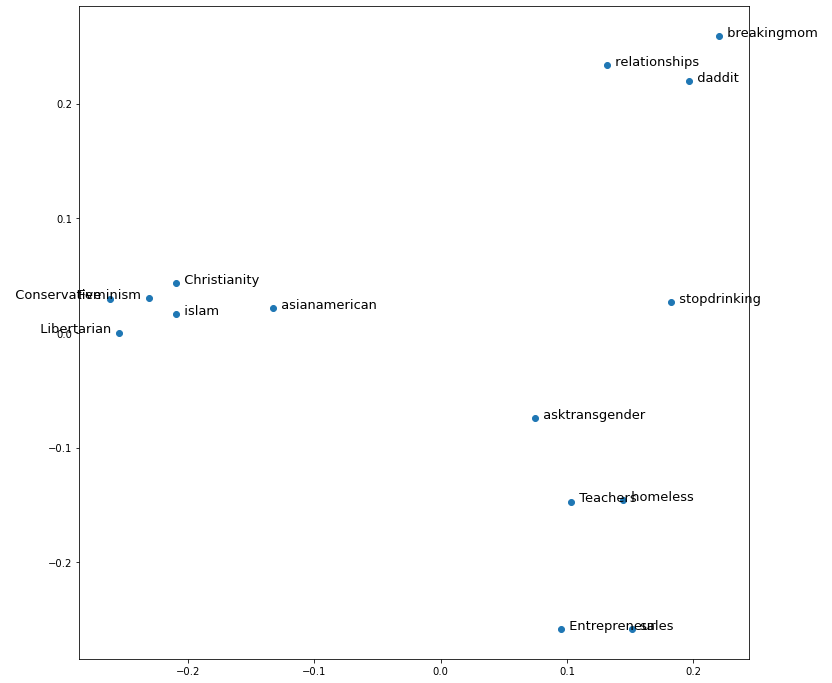

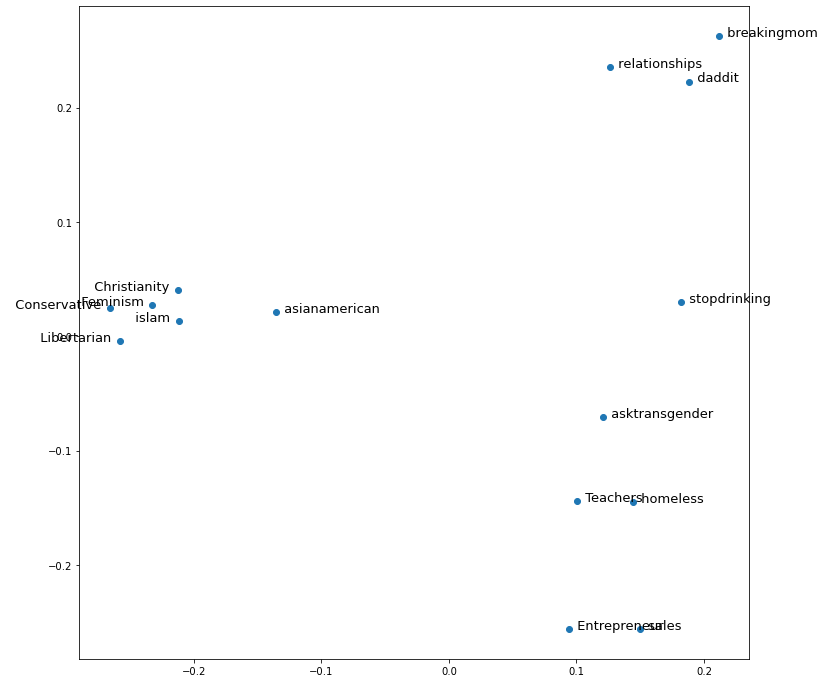

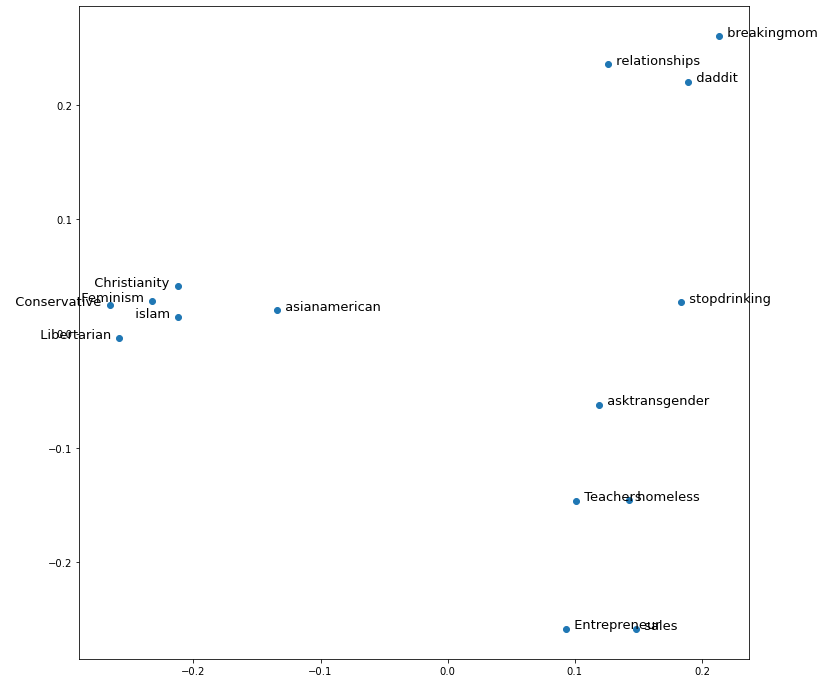

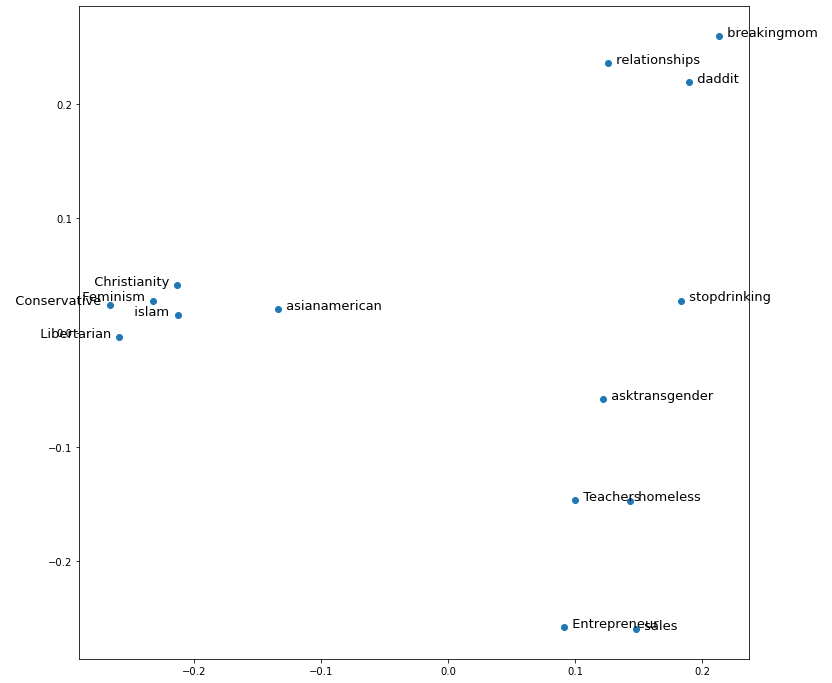

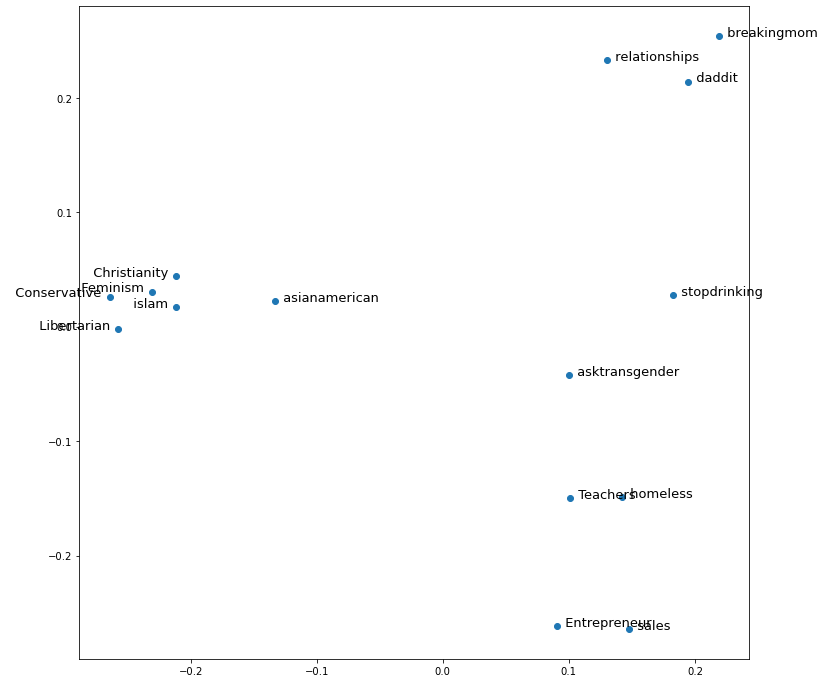

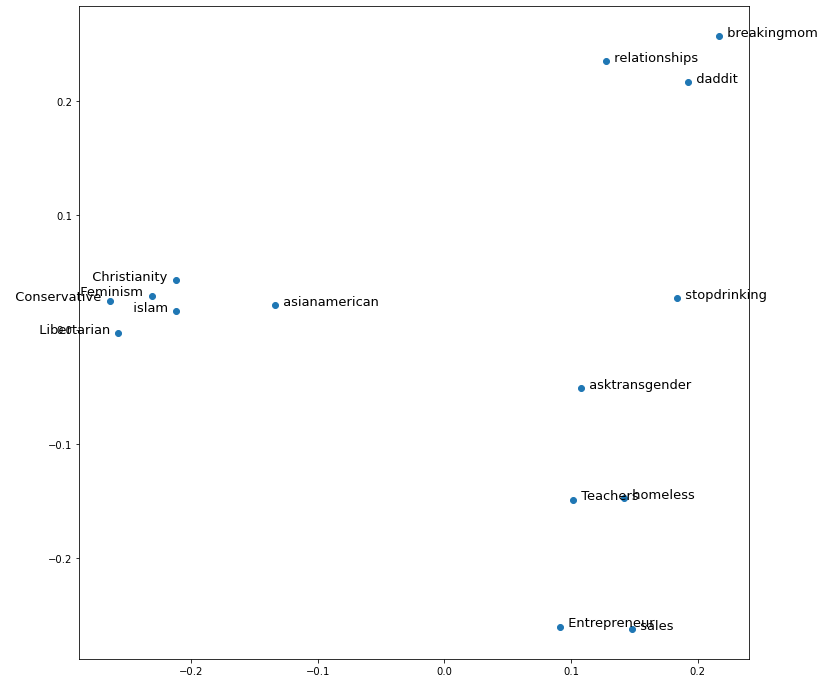

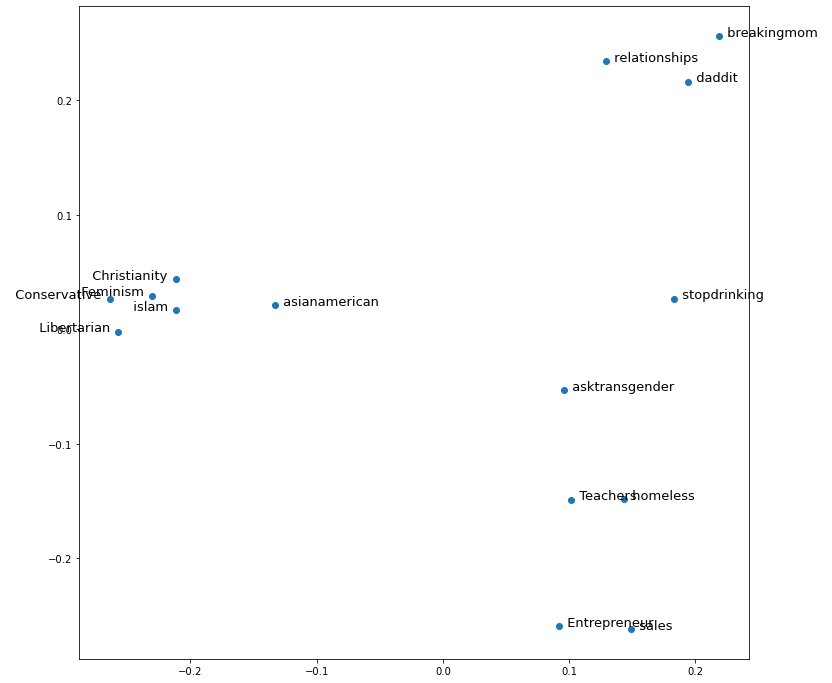

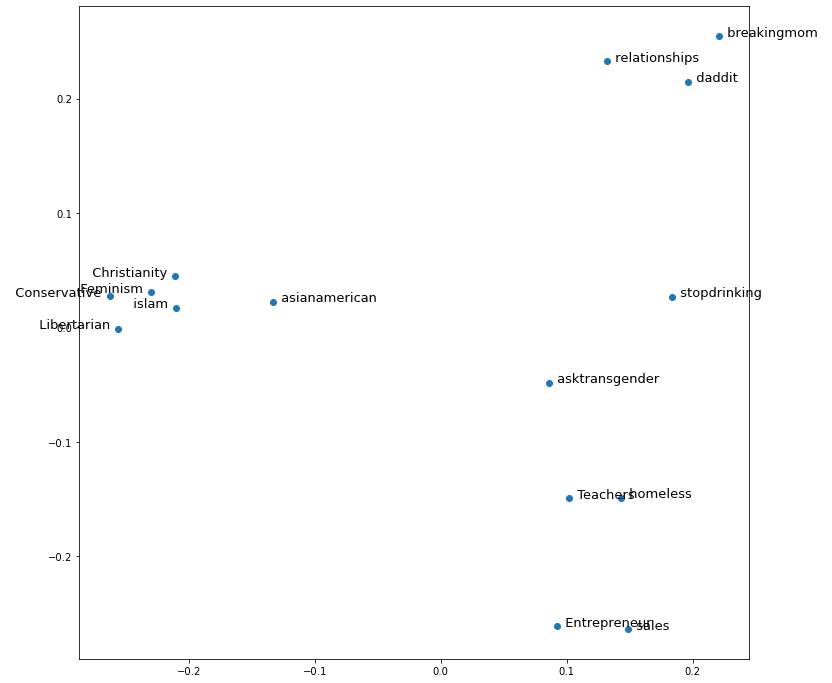

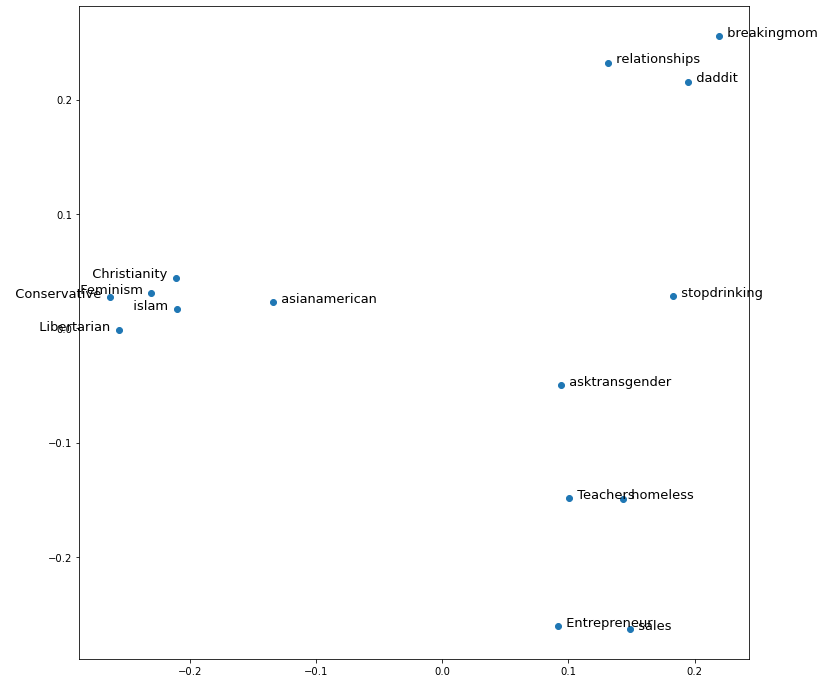

In [34]:
transcoords=[]
save_x=pd.DataFrame()
for tdf in df_list:
    for index, row in tdf.iterrows():
        fourteenids['asktransgender'] = list(row)
        fourteenids.loc['asktransgender'] = list(row)    
        
        D = fourteenids.values 
        D=np.array(D, dtype=float)
        X, evals = mds(D, Q=2)
        plt.figure(figsize=(12, 12))
        plt.scatter(*X.T)

        labels = fourteenids.columns

        for i in range(X.shape[0]): 
            plt.text(X[i,0], X[i,1], '  %s  ' % labels[i],fontsize=13, 
                ha = 'left' if X[i,0] > -0.21 else 'right')

        transcoords.append(X[14])
        X_df = pd. DataFrame(X[0:14], columns=['Column1', 'Column2'])
        save_x = pd.concat([save_x, X_df])
        plt.show()

In [35]:
trans_coords = pd.DataFrame(transcoords, columns=["dimension1", "dimension2"])

In [36]:
trans_coords

,dimension1,dimension2
0,0.074444,-0.073986
1,0.120656,-0.071020
2,0.118975,-0.062027
3,0.121740,-0.058089
4,0.100486,-0.042375
5,0.108048,-0.051346
6,0.095590,-0.052974
7,0.085533,-0.048196
8,0.094088,-0.049646


In [47]:
years_list = ['2011',
              '2012',
              '2013',
              '2014',
              '2015',
              '2016',
              '2017',
              '2018',
              '2019']
trans_coords['year']= years_list
trans_coords['year'] = trans_coords['year'].astype(float)

In [48]:
from scipy.stats import pearsonr
import seaborn as sns


def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 10)
    return pvalues

In [49]:
print(trans_coords.corr(method='spearman'))

print(calculate_pvalues(trans_coords))

            dimension1  dimension2      year
dimension1    1.000000   -0.216667 -0.316667
dimension2   -0.216667    1.000000  0.800000
year         -0.316667    0.800000  1.000000
           dimension1 dimension2      year
dimension1        0.0   0.830743  0.533515
dimension2   0.830743        0.0  0.006955
year         0.533515   0.006955       0.0


Text(0, 0.5, 'MDS X co-ordinate')

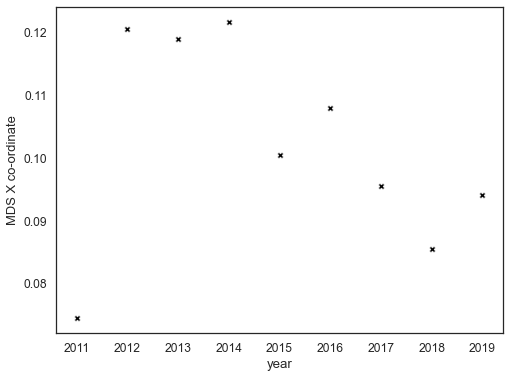

In [92]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set(font_scale=1.1) 
sns.set_style('white')
p = sns.scatterplot(data=trans_coords, y="dimension1", x="year", color='black', marker='X')
p.set_ylabel("MDS X co-ordinate", fontsize = 13)


Text(0, 0.5, 'MDS Y co-ordinate')

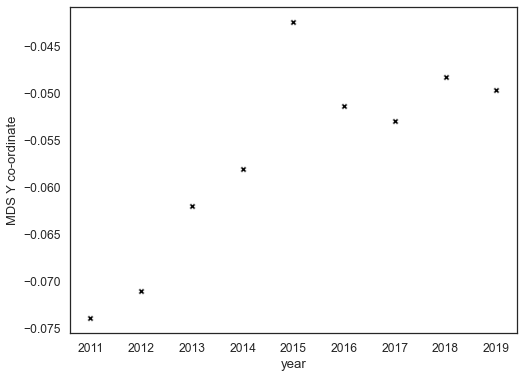

In [91]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set(font_scale=1.1) 
sns.set_style('white')
p = sns.scatterplot(data=trans_coords, y="dimension2", x="year", color='black', marker='X')
p.set_ylabel("MDS Y co-ordinate", fontsize = 13)



In [64]:
transcoordsno2011 = trans_coords.loc[trans_coords['year']!= 2011]

In [65]:
print(transcoordsno2011.corr(method='spearman'))

print(calculate_pvalues(transcoordsno2011))

            dimension1  dimension2      year
dimension1    1.000000   -0.738095 -0.880952
dimension2   -0.738095    1.000000  0.714286
year         -0.880952    0.714286  1.000000
           dimension1 dimension2      year
dimension1        0.0   0.028808  0.002602
dimension2   0.028808        0.0  0.039468
year         0.002602   0.039468       0.0


In [66]:
tc = trans_coords.groupby('year').mean().reset_index(level=0)
tc['type']='transgender by year'

In [67]:
a = list(cols)
a.remove('asktransgender')

In [85]:
coords = mdsdf.drop(13)

In [86]:
coordsdf = pd.DataFrame (coords, columns=['dimension1', 'dimension2'])
coordsdf['year'] = a
coordsdf['type'] = ['vocational','vocational','vocational', 'ethnic/religious','ethnic/religious',
                    'ethnic/religious','political','political','political','relational','relational',
                    'relational','stigmatised','stigmatised']
    

In [88]:
allcoords = pd.concat([trans_coords, coordsdf])
allcoords['hue']=['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', 'non-asktransgender' 
                  , 'non-asktransgender','non-asktransgender',
                  'non-asktransgender','non-asktransgender', 'non-asktransgender','non-asktransgender'
                  ,'non-asktransgender','non-asktransgender', 'non-asktransgender','non-asktransgender',
                  'non-asktransgender','non-asktransgender', 'non-asktransgender']

colors = ['#C0392B',
            '#E74C3C',
            '#9B59B6',
            '#8E44AD',
            '#2980B9',
            '#3498DB',
          '#1ABC9C',
          '#16A085',
          '#196F3D',
         "#1C2833"]


In [89]:
def label_point(x, y, val, ax):
    abc = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in abc.iterrows():
        if str(point['val']) in a:
            ax.text(point['x']+0.003, point['y']+0.002, str(point['val']), ha='left' if  
                    str(point['val']) != 'Conservative' else 'right', fontsize=11)


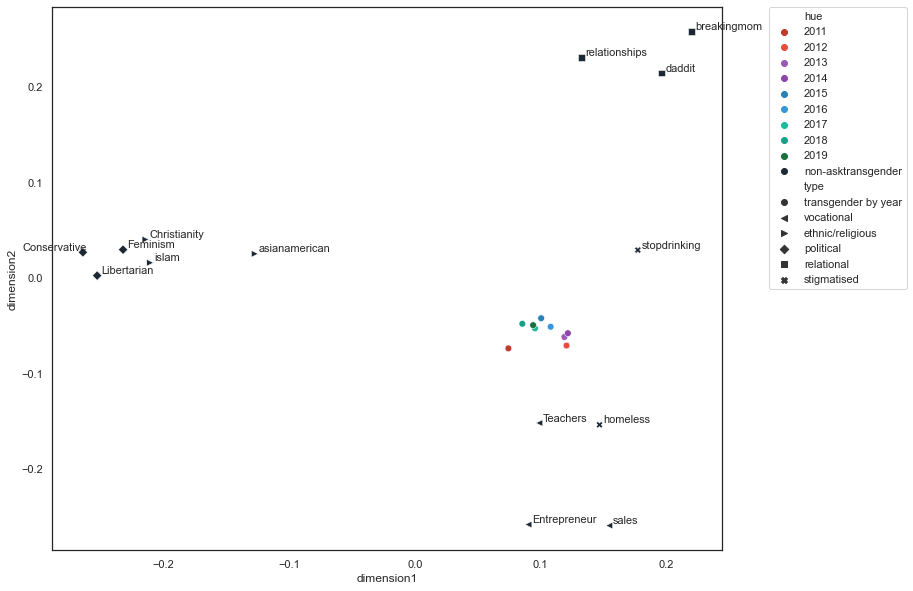

In [90]:
markers = {"transgender by year":"o", "ethnic/religious": ">", "stigmatised": "X", 'political':'D',
           'relational':'s', 'vocational':'<'}


sns.set(rc={'figure.figsize':(12,10)})
sns.set_style('white')

sns.scatterplot(data=allcoords, x="dimension1", y="dimension2", 
                hue='hue', palette=colors,  style='type', markers=markers,
               legend='full',s=45)
plt.legend(bbox_to_anchor=(1.07, 1), loc='upper left',borderaxespad=0)

label_point(allcoords.dimension1, allcoords.dimension2, allcoords.year, plt.gca()) 
